In [30]:
#  NumPy & Pandas
import numpy as np
import pandas as pd

#  Date & Temps
from datetime import datetime, timedelta
import time

#  Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#  Statistiques classiques
from scipy.stats import (
    norm, shapiro, jarque_bera, skew, kurtosis, t
)

#  Tests statistiques séries temporelles
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

#  Machine Learning / Régression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor

#  Optimisation
from scipy.optimize import minimize

# Modèles spécialisés
from arch import arch_model
from pykalman import KalmanFilter

# API / Web
import requests

#  Gestion des warnings
import warnings


# Récuperation des données Via  l'API

In [54]:
# ---- CONFIGURATION ----
cryptos = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']
interval = '1h'
start_date = '2020-02-01'
end_date = '2025-05-01'
limit = 1000  # maximum autorisé par requête

def date_to_ms(date_str):
    dt = datetime.strptime(date_str, "%Y-%m-%d")
    return int(dt.timestamp() * 1000)

def fetch_binance_ohlc(symbol, interval, start_ms, end_ms):
    url = 'https://api.binance.com/api/v3/klines'
    all_data = []
    while start_ms < end_ms:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_ms,
            'endTime': end_ms,
            'limit': limit
        }
        response = requests.get(url, params=params)
        data = response.json()
        if not data:
            break
        all_data.extend(data)
        start_ms = data[-1][0] + 1
        time.sleep(0.3)  # évite le blocage par Binance
    return all_data

def process_ohlc(data, symbol):
    df = pd.DataFrame(data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_volume', 'nb_trades', 'taker_buy_base',
        'taker_buy_quote', 'ignore'
    ])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['close'] = df['close'].astype(float)
    return df[['datetime', 'close']].rename(columns={'close': f'{symbol}_close'})

# ---- TÉLÉCHARGEMENT ----
start_ms = date_to_ms(start_date)
end_ms = date_to_ms(end_date)

merged_df = None
for symbol in cryptos:
    print(f"Téléchargement de {symbol}...")
    raw_data = fetch_binance_ohlc(symbol, interval, start_ms, end_ms)
    df = process_ohlc(raw_data, symbol)
    if merged_df is None:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df, on='datetime', how='outer')

# ---- EXPORT ----
merged_df.sort_values('datetime', inplace=True)
merged_df.to_csv("crypto_hourly_prices_2020_2025.csv", index=False)
print("Fichier exporté : crypto_hourly_prices_2020_2025.csv")


Téléchargement de BTCUSDT...
Téléchargement de ETHUSDT...
Téléchargement de XRPUSDT...
Téléchargement de LTCUSDT...
Téléchargement de DOGEUSDT...
Fichier exporté : crypto_hourly_prices_2020_2025.csv


* Importation des données récupérées

In [31]:
df_crypto = pd.read_csv(r"C:\Users\kadas\Desktop\Mes_cours\chaffik\Data\crypto_hourly_prices_2020_2025.csv", parse_dates=['datetime'])

* forme de la donnée

In [32]:
df_crypto.shape

(45952, 6)

* Vue sur un echantillon

In [34]:
df_crypto.head(5)

,datetime,BTCUSDT_close,ETHUSDT_close,XRPUSDT_close,LTCUSDT_close,DOGEUSDT_close
0,2020-01-31 23:00:00,9352.89,179.99,0.23946,68.00,0.002378
1,2020-02-01 00:00:00,9383.07,181.09,0.24097,68.46,0.002388
2,2020-02-01 01:00:00,9429.86,183.76,0.24265,72.01,0.002400
3,2020-02-01 02:00:00,9441.88,183.88,0.24251,71.70,0.002410
4,2020-02-01 03:00:00,9432.33,183.51,0.24175,72.74,0.002401


* Pourcentage de valeurs manquantes

In [35]:
df_crypto.isna().mean()*100

datetime          0.0
BTCUSDT_close     0.0
ETHUSDT_close     0.0
XRPUSDT_close     0.0
LTCUSDT_close     0.0
DOGEUSDT_close    0.0
dtype: float64

#### Normalisation des données 

In [36]:
def compute_returns(df_prices):
    """
    À partir d’un DataFrame contenant les colonnes *_close, 
    calcule log-return, centered, standardized, abs-standardized pour chaque crypto.
    """
    df = df_prices.copy()
    crypto_cols = [col for col in df.columns if col.endswith('_close')]

    for col in crypto_cols:
        base = col.replace('_close', '')
        
        # Log-returns : Rendement logarithmique horaire de chaque crypto
        df[f'{base}_log_return'] = np.log(df[col] / df[col].shift(1))
        
        # Moyenne et écart-type (en excluant le premier NaN)
        r = df[f'{base}_log_return']
        mean_r = r.mean()
        std_r = r.std()
        
        # Centrage : Rendements centrés autour de la moyenne
        df[f'{base}_log_return_centered'] = r - mean_r
        
        # Standardisation classique
        df[f'{base}_log_return_std'] = (r - mean_r) / std_r
        
        # Valeur absolue (pour NNAR ou Kalman) : 	Volatilité observable, proxy pour l'entraînement & évaluation

        df[f'{base}_abs_std_return'] = df[f'{base}_log_return_std'].abs()

    return df


* Application de la fonction

In [45]:
df_crypto_prepared = compute_returns(df_crypto)
df_crypto_prepared.head(5)

,datetime,BTCUSDT_close,ETHUSDT_close,XRPUSDT_close,LTCUSDT_close,DOGEUSDT_close,BTCUSDT_log_return,BTCUSDT_log_return_centered,BTCUSDT_log_return_std,BTCUSDT_abs_std_return,...,XRPUSDT_log_return_std,XRPUSDT_abs_std_return,LTCUSDT_log_return,LTCUSDT_log_return_centered,LTCUSDT_log_return_std,LTCUSDT_abs_std_return,DOGEUSDT_log_return,DOGEUSDT_log_return_centered,DOGEUSDT_log_return_std,DOGEUSDT_abs_std_return
0,2020-01-31 23:00:00,9352.89,179.99,0.23946,68.00,0.002378,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01 00:00:00,9383.07,181.09,0.24097,68.46,0.002388,0.003222,0.003171,0.453242,0.453242,...,0.540048,0.540048,0.006742,0.006737,0.647038,0.647038,0.004490,0.004397,0.306001,0.306001
2,2020-02-01 01:00:00,9429.86,183.76,0.24265,72.01,0.002400,0.004974,0.004924,0.703722,0.703722,...,0.597325,0.597325,0.050555,0.050551,4.854713,4.854713,0.004679,0.004585,0.319107,0.319107
3,2020-02-01 02:00:00,9441.88,183.88,0.24251,71.70,0.002410,0.001274,0.001224,0.174875,0.174875,...,-0.054139,0.054139,-0.004314,-0.004319,-0.414754,0.414754,0.004366,0.004273,0.297380,0.297380
4,2020-02-01 03:00:00,9432.33,183.51,0.24175,72.74,0.002401,-0.001012,-0.001062,-0.151807,0.151807,...,-0.275919,0.275919,0.014401,0.014396,1.382557,1.382557,-0.003825,-0.003918,-0.272662,0.272662


In [43]:
df_crypto_prepared.columns

Index(['datetime', 'BTCUSDT_close', 'ETHUSDT_close', 'XRPUSDT_close',
       'LTCUSDT_close', 'DOGEUSDT_close', 'BTCUSDT_log_return',
       'BTCUSDT_log_return_centered', 'BTCUSDT_log_return_std',
       'BTCUSDT_abs_std_return', 'ETHUSDT_log_return',
       'ETHUSDT_log_return_centered', 'ETHUSDT_log_return_std',
       'ETHUSDT_abs_std_return', 'XRPUSDT_log_return',
       'XRPUSDT_log_return_centered', 'XRPUSDT_log_return_std',
       'XRPUSDT_abs_std_return', 'LTCUSDT_log_return',
       'LTCUSDT_log_return_centered', 'LTCUSDT_log_return_std',
       'LTCUSDT_abs_std_return', 'DOGEUSDT_log_return',
       'DOGEUSDT_log_return_centered', 'DOGEUSDT_log_return_std',
       'DOGEUSDT_abs_std_return'],
      dtype='object')

 * Analyse exploratoire des rendements (log_return)

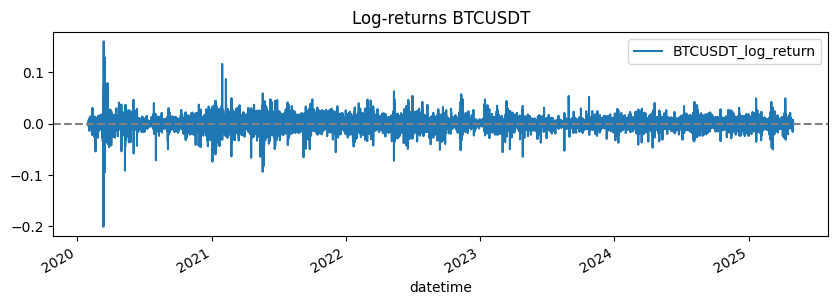

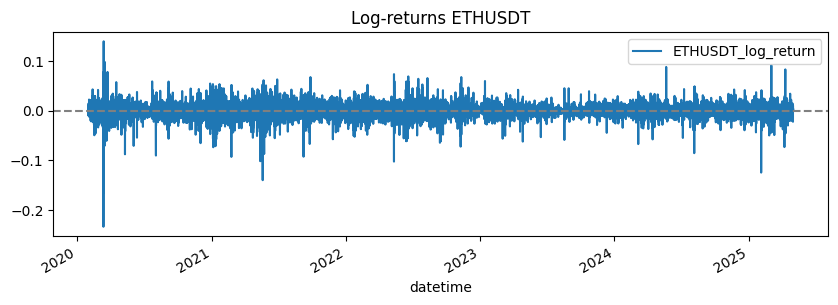

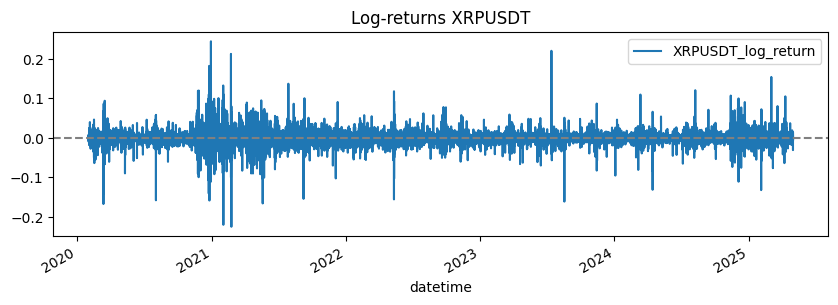

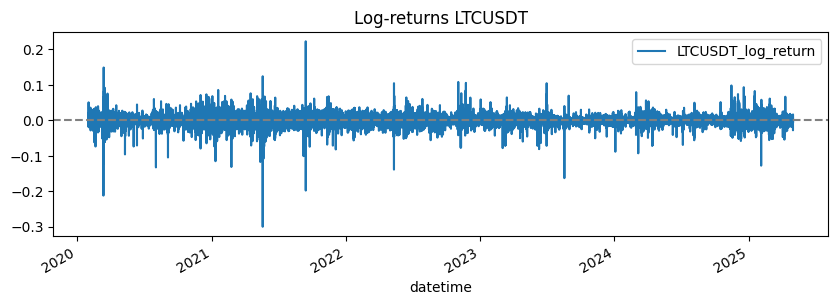

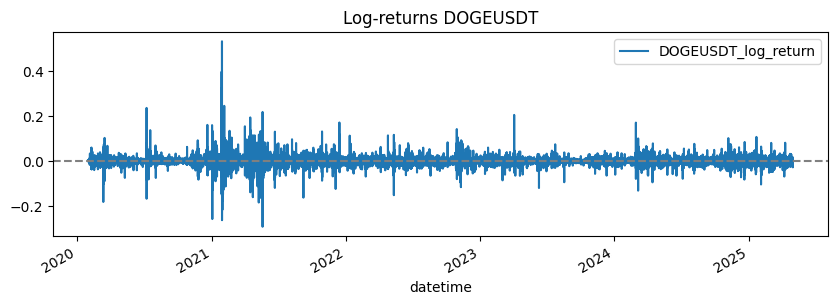

In [39]:
for crypto in ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']:
    df_crypto_prepared.plot(
        x='datetime',
        y=f'{crypto}_log_return',
        title=f'Log-returns {crypto}',
        figsize=(10, 3)
    )
    plt.axhline(0, linestyle='--', color='grey')
    plt.show()


* Histogrammes + courbe normale

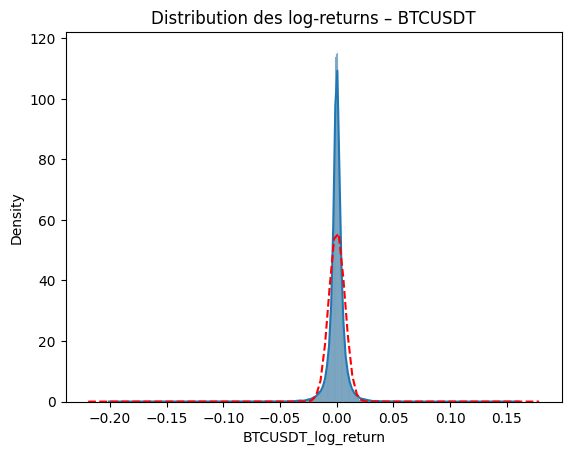

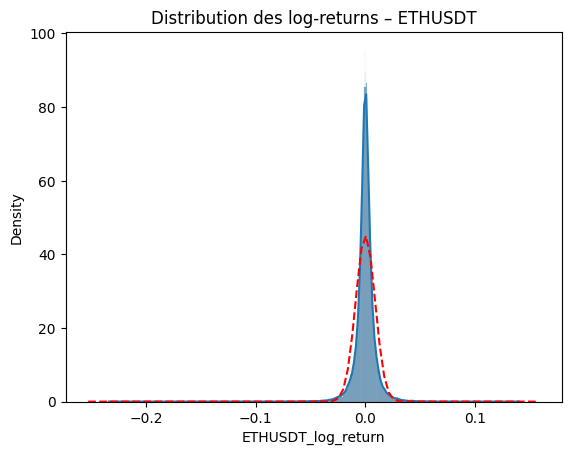

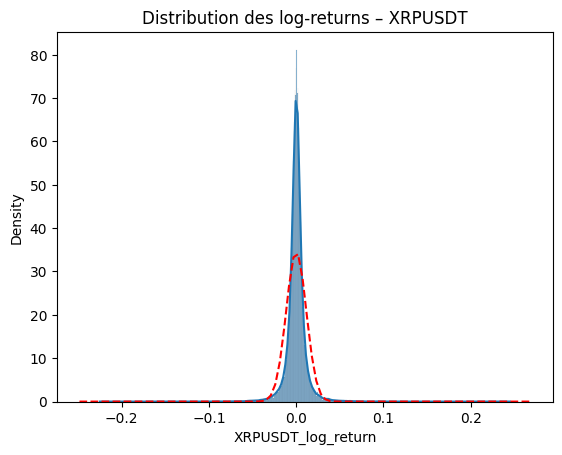

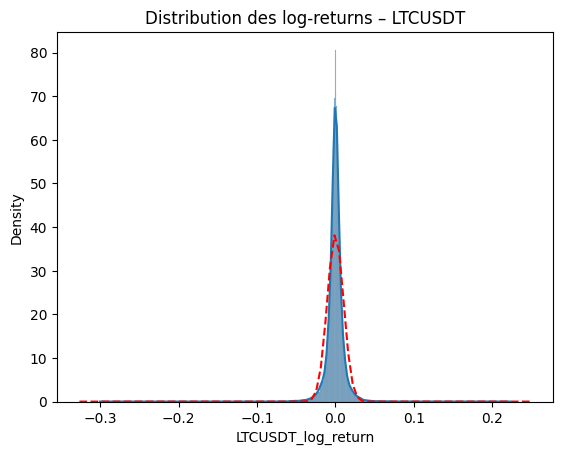

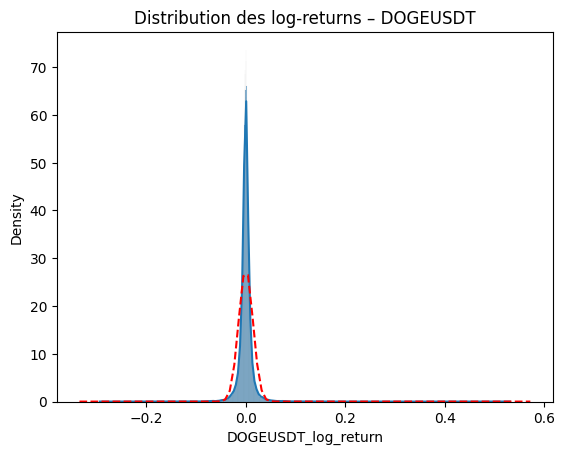

In [40]:
for crypto in ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']:
    r = df_crypto_prepared[f'{crypto}_log_return'].dropna()
    sns.histplot(r, kde=True, stat='density')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    plt.plot(x, norm.pdf(x, r.mean(), r.std()), 'r--')
    plt.title(f'Distribution des log-returns – {crypto}')
    plt.show()


* Skewness & Kurtosis

In [41]:
for crypto in ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']:
    r = df_crypto_prepared[f'{crypto}_log_return'].dropna()
    print(f"{crypto} | Skew: {skew(r):.2f} | Kurtosis: {kurtosis(r):.2f}")

BTCUSDT | Skew: -0.96 | Kurtosis: 52.05
ETHUSDT | Skew: -0.98 | Kurtosis: 29.63
XRPUSDT | Skew: -0.04 | Kurtosis: 41.21
LTCUSDT | Skew: -1.02 | Kurtosis: 41.60
DOGEUSDT | Skew: 2.26 | Kurtosis: 107.06


Remarque : 

DOGEUSDT semble avoir une dynamique explosive avec des pics extrêmes et une tendance haussière forte.

BTC, ETH, XRP et LTC ont des distributions plus équilibrées, bien que BTC et LTC présentent des extrêmes plus prononcés.

# Autocorrélation et stationnarité

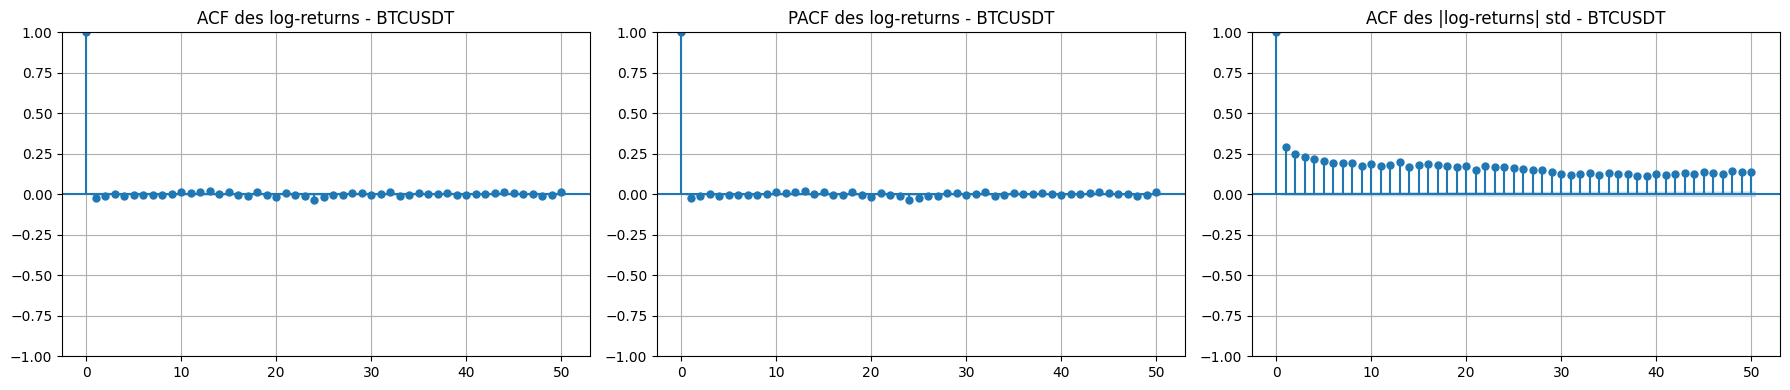

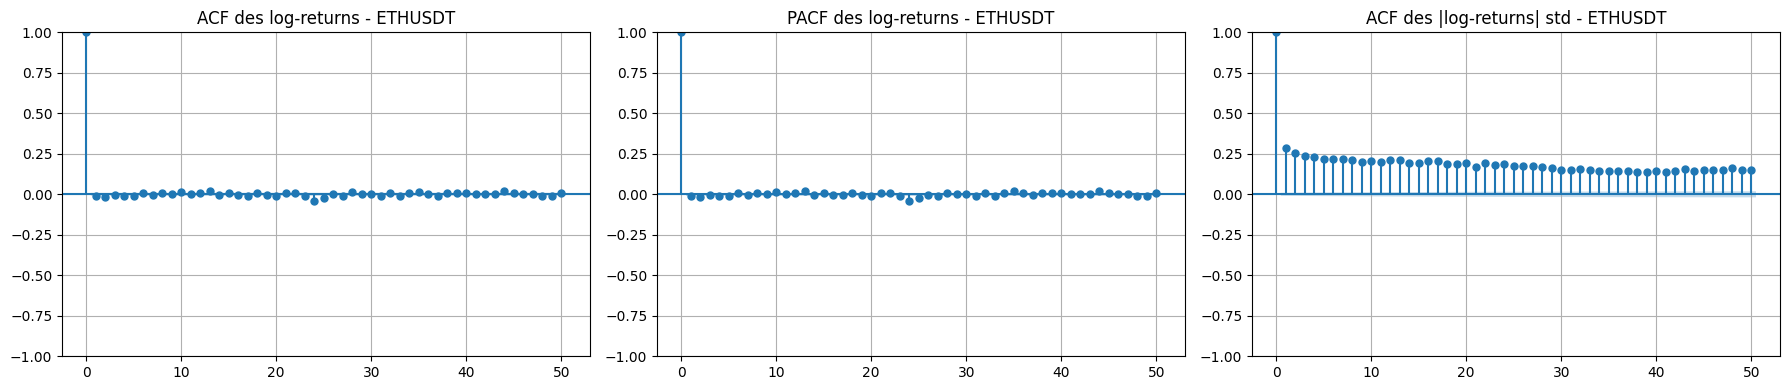

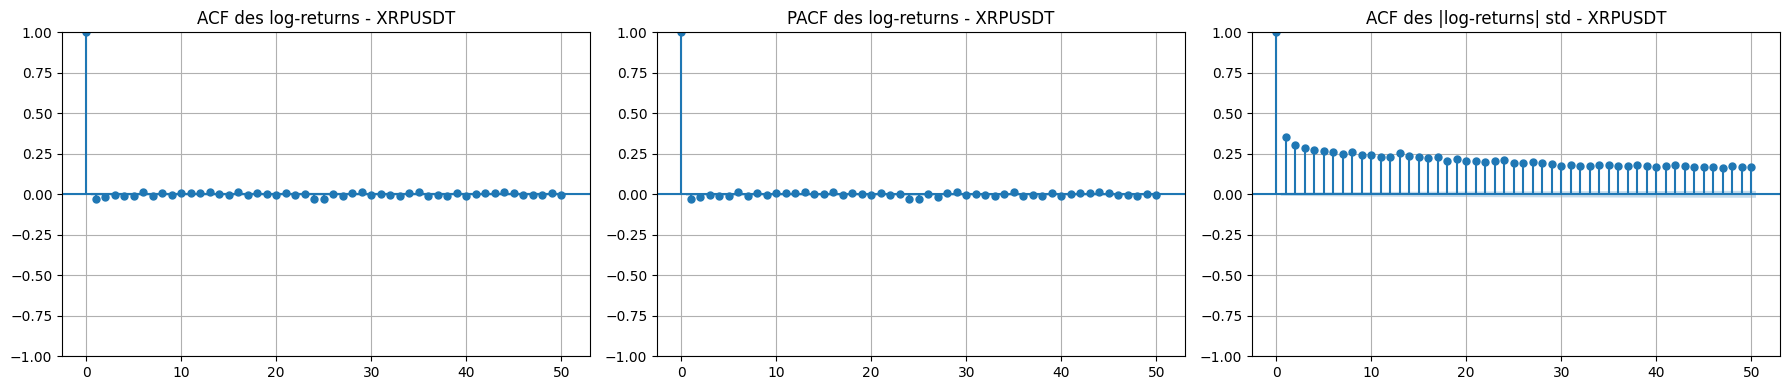

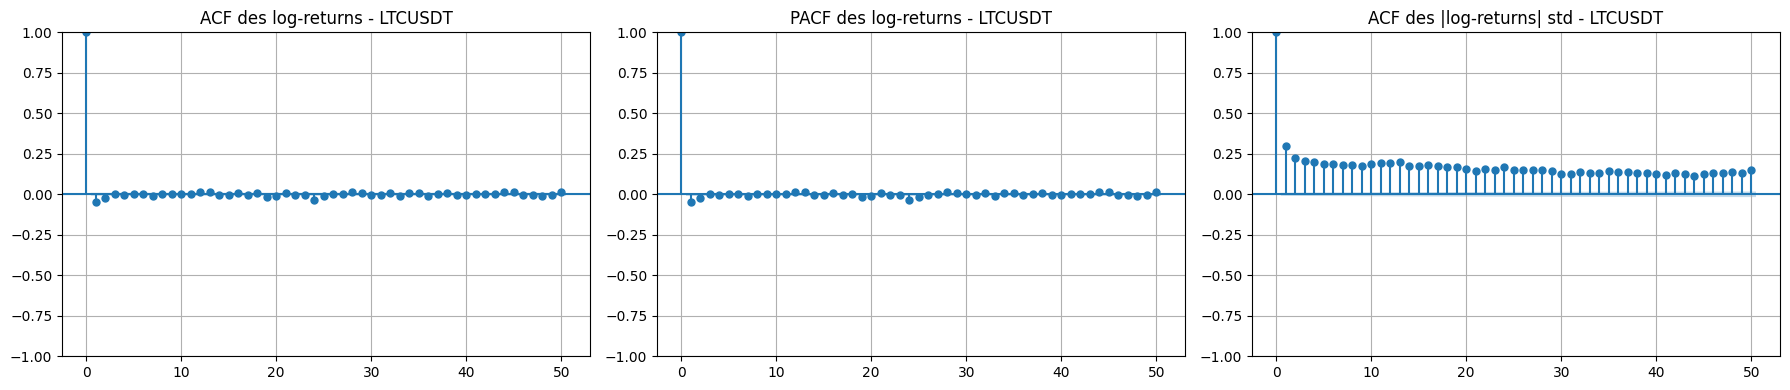

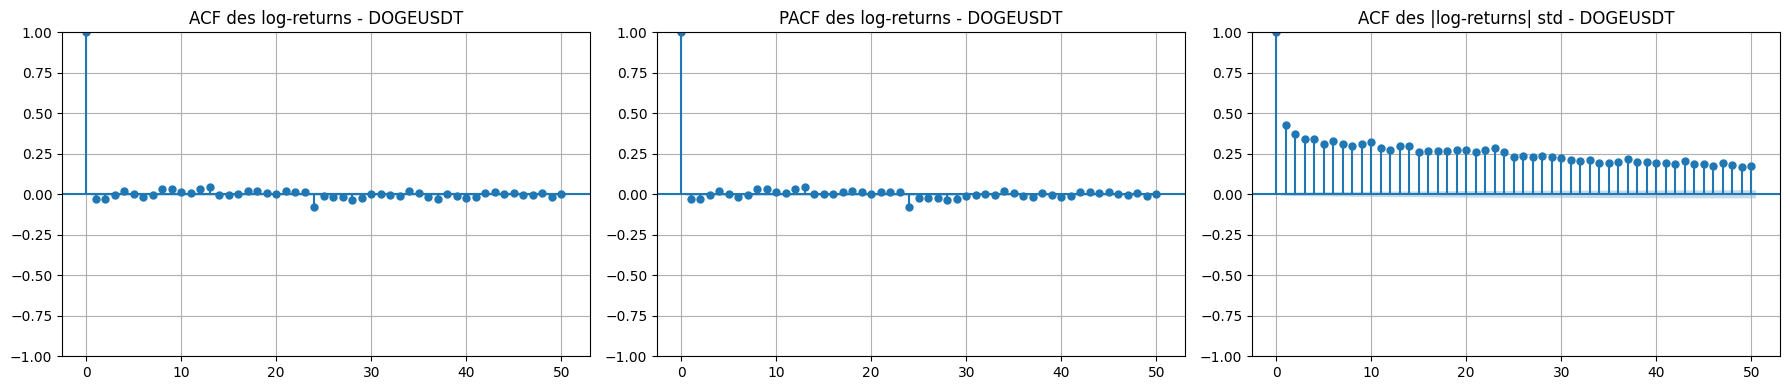

In [46]:
#  ACF / PACF sur log_return et abs_log_return
#  On trace pour chaque crypto :

# ACF des log-returns → autocorrélation des rendements bruts

# ACF des |log-returns| standardisés → autocorrélation de la volatilité implicite

for crypto in cryptos:
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    
    # ACF log-return
    plot_acf(
        df_crypto_prepared[f'{crypto}_log_return'].dropna(),
        lags=50,
        ax=axes[0]
    )
    axes[0].set_title(f"ACF des log-returns - {crypto}")
    axes[0].grid(True)

    # PACF log-return
    plot_pacf(
        df_crypto_prepared[f'{crypto}_log_return'].dropna(),
        lags=50,
        ax=axes[1]
    )
    axes[1].set_title(f"PACF des log-returns - {crypto}")
    axes[1].grid(True)

    # ACF |log-return| standardisé
    plot_acf(
        df_crypto_prepared[f'{crypto}_abs_std_return'].dropna(),
        lags=50,
        ax=axes[2]
    )
    axes[2].set_title(f"ACF des |log-returns| std - {crypto}")
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()
    
    # a l'extreme droite  on voit l’autocorrélation de la volatilité


 Remarque :
 l’analyse ACF/PACF confirme l’absence d’autocorrélation dans les rendements bruts, tandis que les valeurs absolues standardisées présentent une forte dépendance temporelle. Cela confirme que la dynamique utile à modéliser est celle de la volatilité latente, justifiant l’usage de filtres de Kalman pour extraire cette composante invisible. 

* Test de stationnarité (Augmented Dickey-Fuller)

In [15]:
for crypto in ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']:
    r = df_crypto_prepared[f'{crypto}_log_return'].dropna()
    adf = adfuller(r)
    print(f"{crypto} – ADF Statistic: {adf[0]:.3f}, p-value: {adf[1]:.3f}")

BTCUSDT – ADF Statistic: -29.785, p-value: 0.000
ETHUSDT – ADF Statistic: -29.616, p-value: 0.000
XRPUSDT – ADF Statistic: -31.329, p-value: 0.000
LTCUSDT – ADF Statistic: -30.356, p-value: 0.000
DOGEUSDT – ADF Statistic: -29.055, p-value: 0.000


Les p-value < 0.05, on rejette H₀ → la série est stationnaire , Tous les log-returns de cryptos sont en général stationnaires, ce qui est une bonne base pour les modèles

# Construction d’une série de volatilité observée

On construis pour chaque crypto une série de volatilité observée lissée, en prenant la moyenne mobile des rendements standardisés absolus sur un pas de 24 heures.

On a donc généré une série de volatilité observée (vol_obs) à partir des log-returns standardisés, en utilisant une moyenne mobile glissante

C’est notre vérité terrain pour la comparaison des modèles elle servira de benchmark ppur  pouvoir évaluer les performances des modèles.


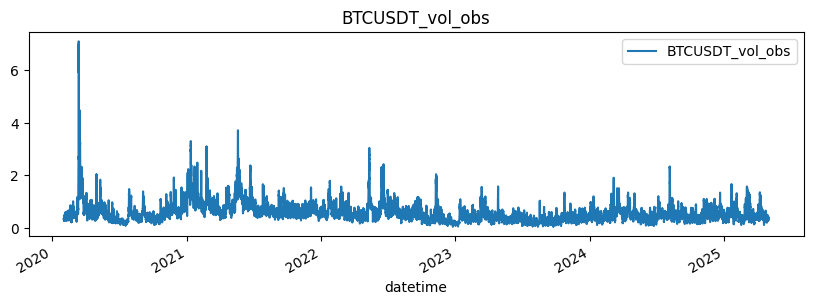

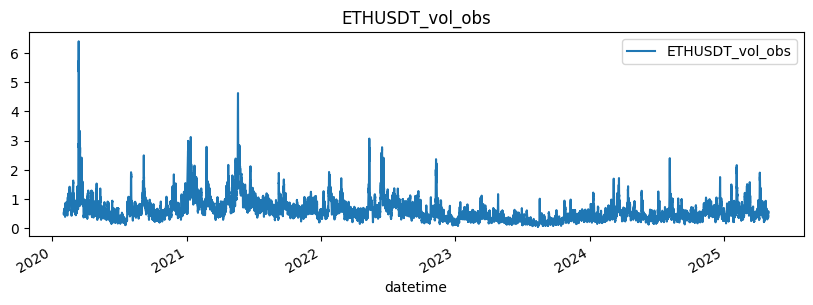

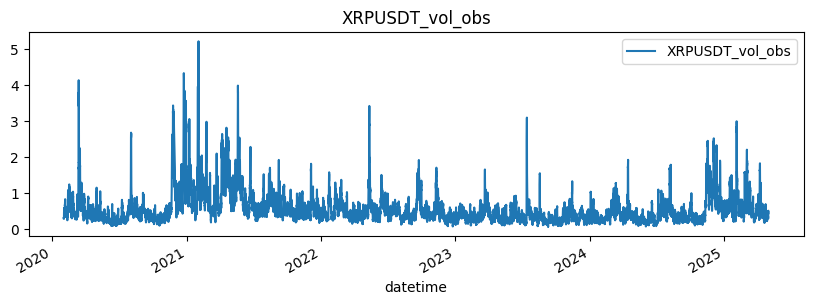

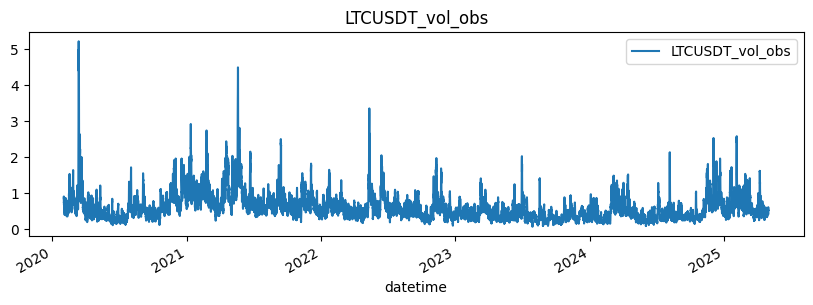

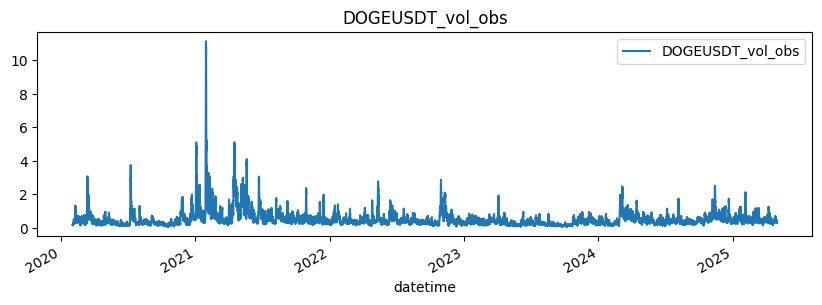

In [47]:
# Détecte toutes les colonnes *_abs_std_return automatiquement
vol_columns = [col for col in df_crypto_prepared.columns if col.endswith('_abs_std_return')]

for col in vol_columns:
    base = col.replace('_abs_std_return', '')  # ex: BTCUSDT ou BTC selon renommage
    df_crypto_prepared[f'{base}_vol_obs'] = df_crypto_prepared[col].rolling(window=24).mean()
for col in df_crypto_prepared.columns:
    if col.endswith('_vol_obs'):
        df_crypto_prepared.plot(x='datetime', y=col, title=col, figsize=(10, 3))
        plt.show()

In [48]:
df_crypto_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45952 entries, 0 to 45951
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   datetime                      45952 non-null  datetime64[ns]
 1   BTCUSDT_close                 45952 non-null  float64       
 2   ETHUSDT_close                 45952 non-null  float64       
 3   XRPUSDT_close                 45952 non-null  float64       
 4   LTCUSDT_close                 45952 non-null  float64       
 5   DOGEUSDT_close                45952 non-null  float64       
 6   BTCUSDT_log_return            45951 non-null  float64       
 7   BTCUSDT_log_return_centered   45951 non-null  float64       
 8   BTCUSDT_log_return_std        45951 non-null  float64       
 9   BTCUSDT_abs_std_return        45951 non-null  float64       
 10  ETHUSDT_log_return            45951 non-null  float64       
 11  ETHUSDT_log_return_centered 

# Implémentation des modèles : 

#### 1 /  Création et application d'un modèle GARCH(1,1) pour prédire la volatilité des cryptomonnaies

In [49]:


# Supprimer les avertissements de convergence
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def apply_garch_to_crypto(df, symbol, plot=True, save_fig=True, output_dir="./"):
    """
    Applique un GARCH(1,1) Student-t à {symbol}_log_return_centered.
    Affiche la comparaison volatilité observée vs prédite.
    Calcule RMSE / MAE.
    """
    col_centered = f"{symbol}_log_return_centered"
    col_std_abs = f"{symbol}_abs_std_return"

    if col_centered not in df.columns or col_std_abs not in df.columns:
        raise KeyError(f"Colonnes manquantes : {col_centered} ou {col_std_abs}")

    # Série entrée GARCH : centrée et multipliée par 100
    series = df[col_centered].dropna() * 100

    # Observée = rolling sur abs(log_return_std), en pourcentage aussi
    obs_vol = df[col_std_abs].dropna().rolling(24).mean().dropna()

    # Modèle GARCH (résolu sans method explicite)
    model = arch_model(series, mean='Constant', vol='GARCH', p=1, q=1, dist='t')
    result = model.fit(disp='off')
    pred_vol = result.conditional_volatility / 100  # on revient à l’échelle normale (ratio)

    # Alignement des deux séries
    min_len = min(len(obs_vol), len(pred_vol))
    obs_aligned = obs_vol[-min_len:]
    pred_aligned = pred_vol[-min_len:]
    x = range(min_len)

    # Graphique
    if plot or save_fig:
        fig, ax = plt.subplots(figsize=(10, 3))
        ax.plot(x, obs_aligned.values, label="Volatilité observée (rolling)", color="orange", linewidth=1.5)
        ax.plot(x, pred_aligned.values, label="Volatilité prédite (GARCH)", color="green", linewidth=1.5)
        ax.set_title(f"{symbol} – Observée vs Prédite (GARCH)")
        ax.set_xlabel("Heures")
        ax.set_ylabel("Volatilité (ratio)")
        ax.grid(True)
        ax.legend()
        plt.tight_layout()

        if save_fig:
            fig_path = f"{output_dir}GARCH_vs_Obs_{symbol}.png"
            plt.savefig(fig_path, dpi=150)
            print(f"Figure sauvegardée : {fig_path}")

        if plot:
            plt.show()
        else:
            plt.close()

    # Calcul des métriques d'erreur
    rmse = np.sqrt(mean_squared_error(obs_aligned, pred_aligned))
    mae = mean_absolute_error(obs_aligned, pred_aligned)

    return result, pred_aligned, rmse, mae


Modélisation GARCH pour BTCUSDT...
Figure sauvegardée : ./GARCH_vs_Obs_BTCUSDT.png


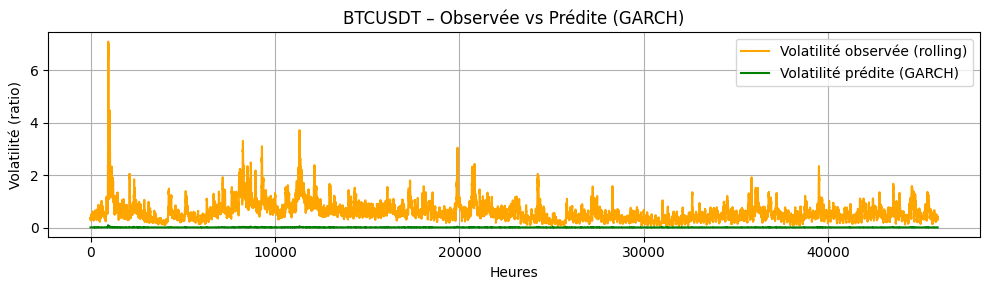


Modélisation GARCH pour ETHUSDT...
Figure sauvegardée : ./GARCH_vs_Obs_ETHUSDT.png


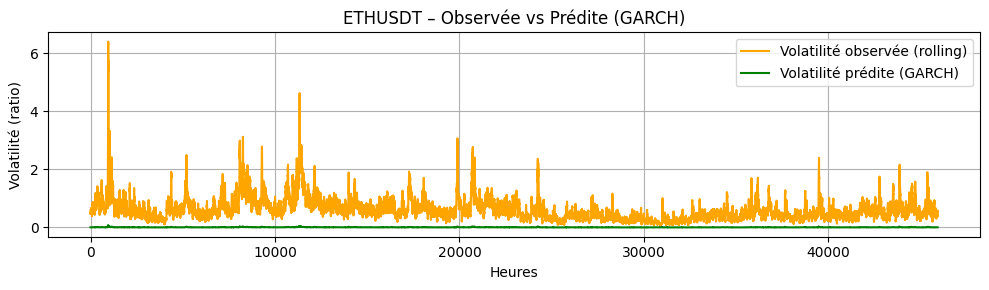


Modélisation GARCH pour XRPUSDT...
Figure sauvegardée : ./GARCH_vs_Obs_XRPUSDT.png


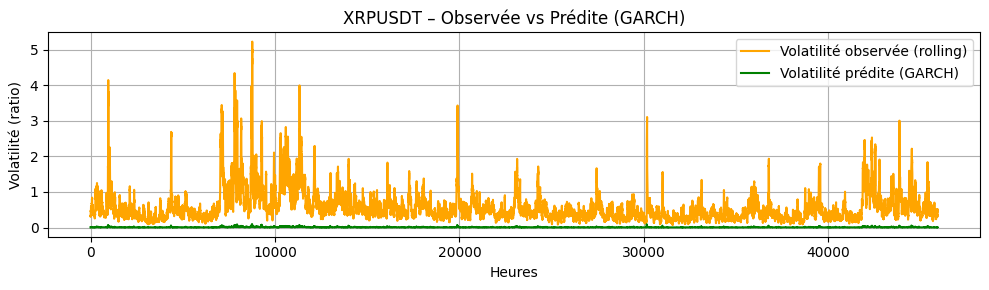


Modélisation GARCH pour LTCUSDT...
Figure sauvegardée : ./GARCH_vs_Obs_LTCUSDT.png


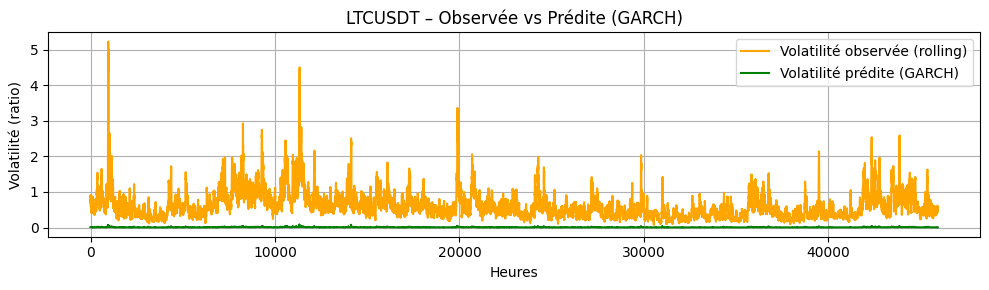


Modélisation GARCH pour DOGEUSDT...


c:\Users\kadas\Desktop\Mes_cours\chaffik\.venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Figure sauvegardée : ./GARCH_vs_Obs_DOGEUSDT.png


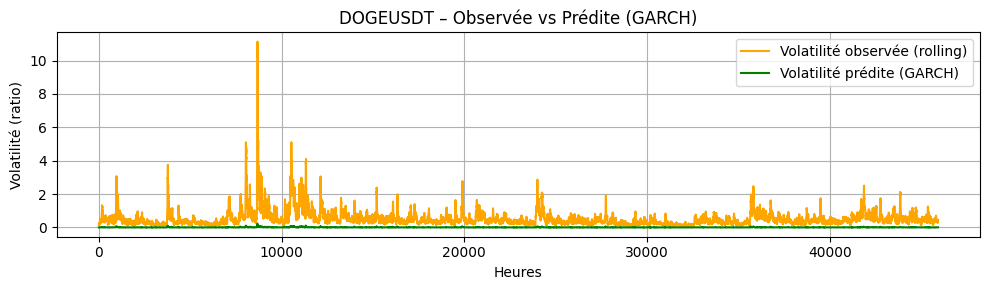


Résumé des erreurs GARCH :
     Crypto      RMSE       MAE
0   BTCUSDT  0.709075  0.593683
2   XRPUSDT  0.712338  0.562505
4  DOGEUSDT  0.713714  0.516790
3   LTCUSDT  0.714826  0.610086
1   ETHUSDT  0.723494  0.607877


In [50]:
crypto_list = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']

garch_models = {}
volatility_series = {}
garch_metrics = []

for symbol in crypto_list:
    print(f"\nModélisation GARCH pour {symbol}...")
    result, vol_pred, rmse, mae = apply_garch_to_crypto(df_crypto_prepared, symbol, plot=True)
    garch_models[symbol] = result
    volatility_series[symbol] = vol_pred
    garch_metrics.append({
        "Crypto": symbol,
        "RMSE": rmse,
        "MAE": mae
    })

# Résumé erreurs
df_garch_errors = pd.DataFrame(garch_metrics)
print("\nRésumé des erreurs GARCH :")
print(df_garch_errors.sort_values("RMSE"))

* VaR + IC + largeur IC pour un modèle GARCH

In [62]:
from scipy.stats import norm

alpha = 0.01  # Niveau de confiance (99 %)
z_score = norm.ppf(alpha)  # ≈ -2.33

garch_ic_metrics = []

for symbol in crypto_list:
    print(f"\n{symbol} – Calcul de VaR et IC pour GARCH")

    # Volatilité prédite déjà lissée et alignée
    vol_pred = volatility_series[symbol]  # np.array ou pd.Series

    # Log-returns centrés à comparer (même longueur que vol_pred)
    y = df_crypto_prepared[f"{symbol}_log_return_centered"].dropna().tail(len(vol_pred)).values

    # Résidus
    residuals = y - vol_pred

    # VaR (à 99 %)
    var_pred = -vol_pred * z_score

    # IC basé sur quantiles des résidus
    IC_min = vol_pred + np.quantile(residuals, alpha / 2)
    IC_max = vol_pred + np.quantile(residuals, 1 - alpha / 2)
    IC_width = IC_max - IC_min
    mean_ic_width = IC_width.mean()

    print(f"{symbol} – Largeur moyenne IC GARCH : {mean_ic_width:.6f}")

    # Enregistrer dans un tableau pour comparaison finale
    garch_ic_metrics.append({
        "Crypto": symbol,
        "IC_Width": mean_ic_width,
        "VaR_Mean": var_pred.mean(),  # optionnel : moyenne des VaR
    })

# Résumé final
df_garch_ic = pd.DataFrame(garch_ic_metrics)
display(df_garch_ic)



BTCUSDT – Calcul de VaR et IC pour GARCH
BTCUSDT – Largeur moyenne IC GARCH : 0.055159

ETHUSDT – Calcul de VaR et IC pour GARCH
ETHUSDT – Largeur moyenne IC GARCH : 0.070020

XRPUSDT – Calcul de VaR et IC pour GARCH
XRPUSDT – Largeur moyenne IC GARCH : 0.098714

LTCUSDT – Calcul de VaR et IC pour GARCH
LTCUSDT – Largeur moyenne IC GARCH : 0.080261

DOGEUSDT – Calcul de VaR et IC pour GARCH
DOGEUSDT – Largeur moyenne IC GARCH : 0.120966


,Crypto,IC_Width,VaR_Mean
0,BTCUSDT,0.055159,0.014267
1,ETHUSDT,0.070020,0.018235
2,XRPUSDT,0.098714,0.022189
3,LTCUSDT,0.080261,0.021867
4,DOGEUSDT,0.120966,0.025411


Crypto	IC_Width (GARCH)	Conclusion rapide
BTCUSDT	0.055	 Le plus stable
DOGEUSDT	0.121	 Le plus incertain (logique, c’est la plus volatile)

C’est cohérent économiquement : DOGE est plus instable → IC plus large.
Et techniquement défendable : plus l’IC est resserré, plus la précision du modèle est forte.



### 2/ Implémentation du modèle NNAR

In [51]:

# Assurez-vous que ce DataFrame existe déjà
df = df_crypto_prepared

# Liste des cryptomonnaies à tester
crypto_list = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']

# Résultats stockés dans une liste de dictionnaires
results = []

for symbol in crypto_list:
    try:
        series = df[f"{symbol}_abs_std_return"].dropna()

        # Test de Ljung-Box : autocorrélation
        lb_pvalue = acorr_ljungbox(series, lags=[10], return_df=True)['lb_pvalue'].values[0]
        lb_result = 'Oui' if lb_pvalue < 0.05 else 'Non'

        # Test ADF : stationnarité (facultatif)
        adf_pvalue = adfuller(series)[1]
        adf_result = 'Oui' if adf_pvalue < 0.05 else 'Non'

        results.append({
            "Crypto": symbol,
            "Autocorrélation détectée (Ljung-Box)": lb_result,
            "Stationnarité (ADF, facultatif)": adf_result
        })

    except Exception as e:
        results.append({
            "Crypto": symbol,
            "Autocorrélation détectée (Ljung-Box)": "Erreur",
            "Stationnarité (ADF, facultatif)": "Erreur"
        })

# Création du DataFrame final
df_results = pd.DataFrame(results)
print("Résumé des hypothèses vérifiées pour le modèle NNAR :")
display(df_results)

Résumé des hypothèses vérifiées pour le modèle NNAR :


,Crypto,Autocorrélation détectée (Ljung-Box),"Stationnarité (ADF, facultatif)"
0,BTCUSDT,Oui,Oui
1,ETHUSDT,Oui,Oui
2,XRPUSDT,Oui,Oui
3,LTCUSDT,Oui,Oui
4,DOGEUSDT,Oui,Oui


NNAR pour BTCUSDT...


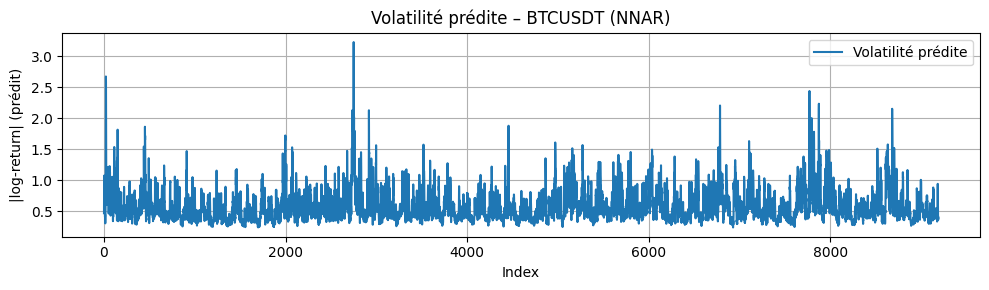

NNAR pour ETHUSDT...


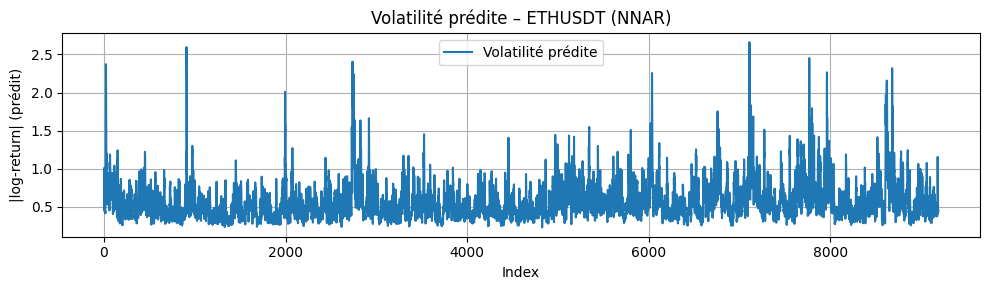

NNAR pour XRPUSDT...


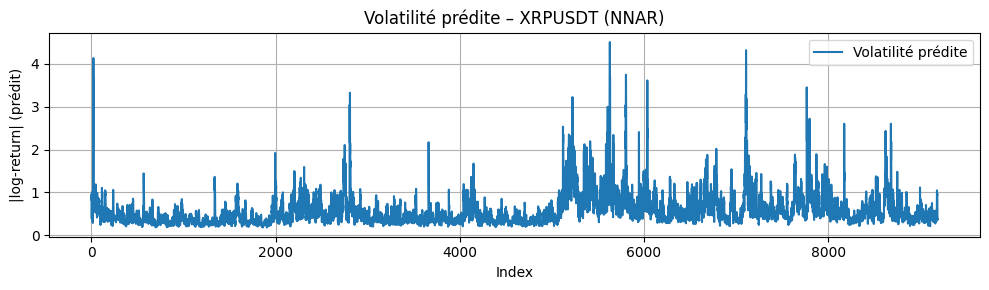

NNAR pour LTCUSDT...


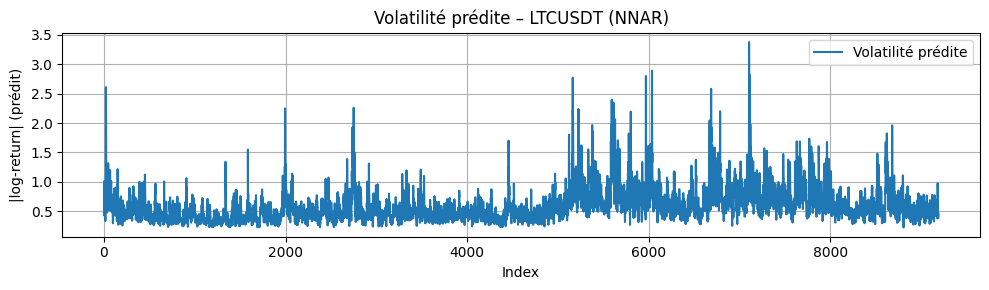

NNAR pour DOGEUSDT...


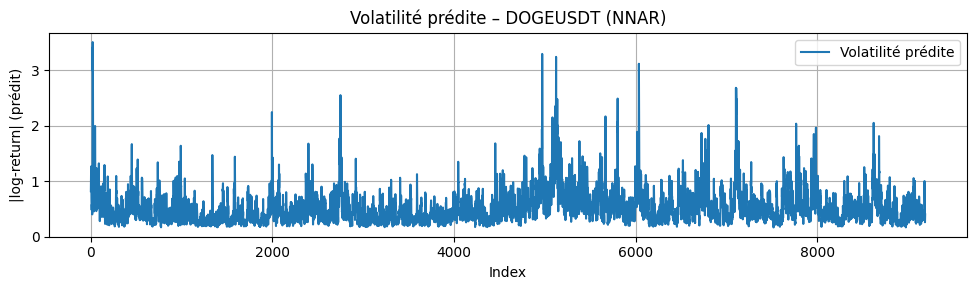

In [52]:
# Fonction renommée pour correspondre au modèle NNAR
def prepare_nnar_input_data(series, p):
    """
    Transforme une série temporelle en données supervisées pour NNAR.
    Retourne X (lags) et y (cible).
    """
    X, y = [], []
    for i in range(p, len(series)):
        X.append(series[i - p:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Paramètres NNAR
p = 5
k = 10

# Liste automatique des cryptos dans le DataFrame
crypto_list = [col.replace('_abs_std_return', '') for col in df_crypto_prepared.columns if col.endswith('_abs_std_return')]

# Dictionnaire pour stocker les prédictions
nnar_predictions = {}

for symbol in crypto_list:
    try:
        print(f"NNAR pour {symbol}...")

        series = df_crypto_prepared[f"{symbol}_abs_std_return"].dropna().values

        # Préparation des données d’entrée
        X, y = prepare_nnar_input_data(series, p)
        split_idx = int(0.8 * len(X))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train = y[:split_idx]

        # Modèle NNAR (MLP)
        model = MLPRegressor(hidden_layer_sizes=(k,), activation='relu', max_iter=1000, random_state=0)
        model.fit(X_train, y_train)

        # Prédiction
        y_pred = model.predict(X_test)
        nnar_predictions[symbol] = y_pred

        # Affichage du graphique
        plt.figure(figsize=(10, 3))
        plt.plot(y_pred, label='Volatilité prédite')
        plt.title(f"Volatilité prédite – {symbol} (NNAR)")
        plt.xlabel("Index")
        plt.ylabel("|log-return| (prédit)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Erreur pour {symbol} : {e}")

#### Métriques d'évaluation du modèle NNAR

In [53]:
# Stockage des métriques
nnar_metrics = []
p = 5  # doit correspondre au lag utilisé dans la prédiction NNAR

for symbol in crypto_list:
    try:
        # Recharger les vraies données
        series = df_crypto_prepared[f"{symbol}_abs_std_return"].dropna().values
        X, y = prepare_nnar_input_data(series, p)
        split_idx = int(0.8 * len(X))
        y_test = y[split_idx:]

        y_pred = nnar_predictions.get(symbol, None)

        if y_pred is not None and len(y_pred) == len(y_test):
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)

            nnar_metrics.append({
                "Crypto": symbol,
                "RMSE": rmse,
                "MAE": mae
            })
        else:
            raise ValueError("Taille de prédiction invalide ou absente")

    except Exception as e:
        print(f"Erreur sur les métriques pour {symbol} : {e}")
        nnar_metrics.append({
            "Crypto": symbol,
            "RMSE": "Erreur",
            "MAE": "Erreur"
        })

# Résultat
df_nnar_metrics = pd.DataFrame(nnar_metrics)
print(df_nnar_metrics)

     Crypto      RMSE       MAE
0   BTCUSDT  0.589666  0.394351
1   ETHUSDT  0.636573  0.396688
2   XRPUSDT  0.672245  0.392588
3   LTCUSDT  0.641932  0.403322
4  DOGEUSDT  0.556032  0.361710


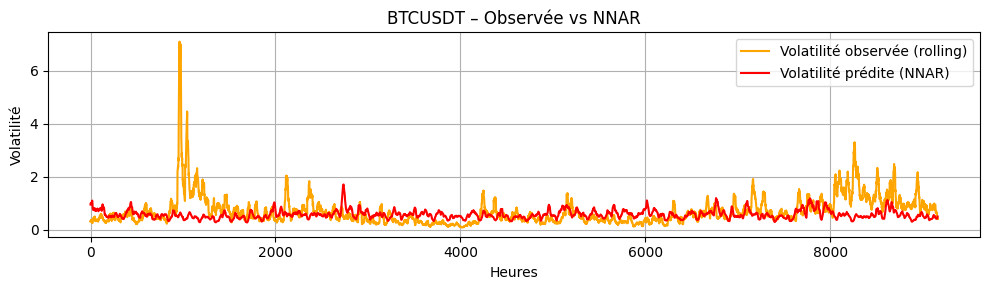

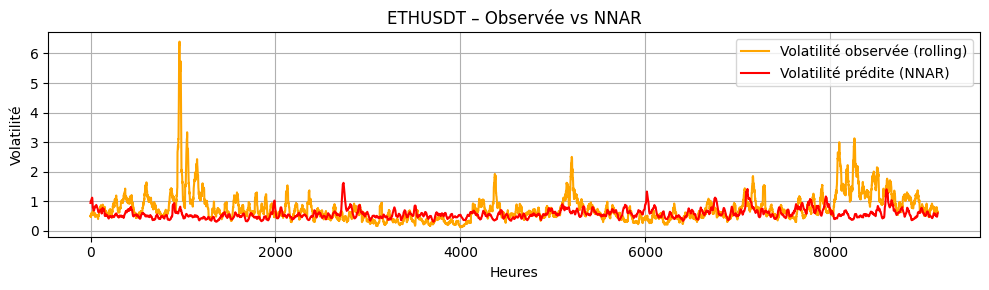

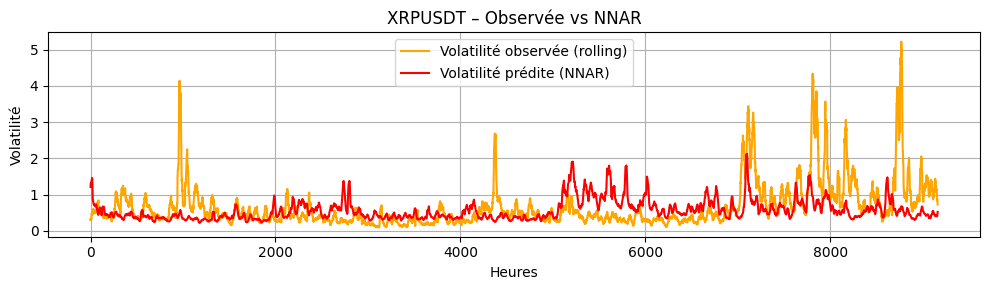

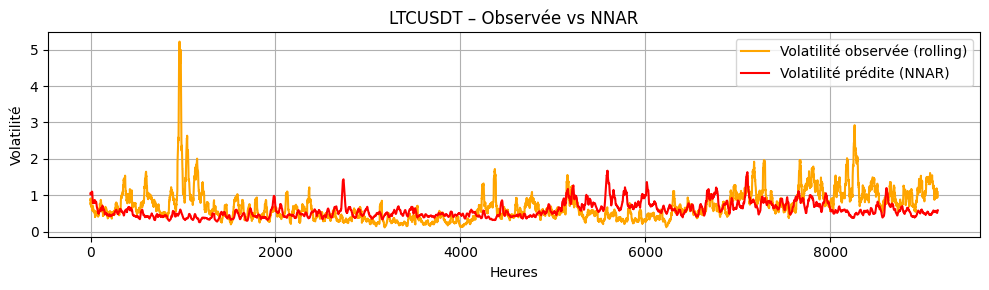

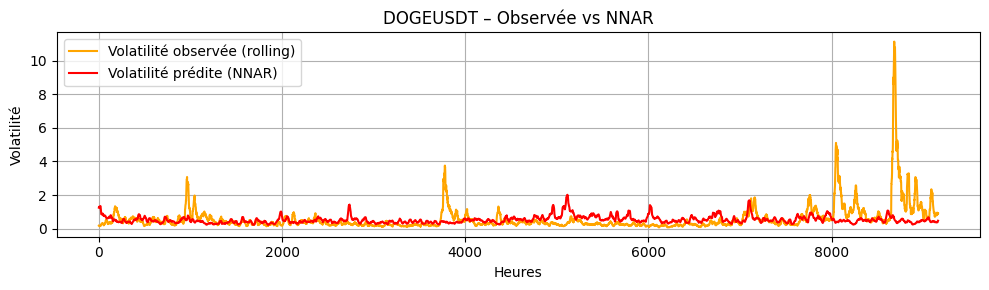

In [54]:
p = 5  # même lag que pour l'entraînement

for symbol in crypto_list:
    try:
        # Observée (proxy)
        vol_obs = df_crypto_prepared[f"{symbol}_abs_std_return"].dropna().rolling(window=24).mean().dropna().values

        # Prédiction NNAR (y_pred sur test uniquement)
        series = df_crypto_prepared[f"{symbol}_abs_std_return"].dropna().values
        total_len = len(series)
        pred = nnar_predictions[symbol]
        split_idx = int(0.8 * total_len)

        # Reconstruire la série complète alignée
        full_pred = np.full(total_len, np.nan)
        insertion_start = split_idx + p
        insertion_end = insertion_start + len(pred)

        if insertion_end > total_len:
            pred = pred[:total_len - insertion_start]
            insertion_end = total_len

        full_pred[insertion_start:insertion_end] = pred
        vol_pred = pd.Series(full_pred).rolling(window=24).mean().dropna().values

        # Alignement
        min_len = min(len(vol_obs), len(vol_pred))
        x = range(min_len)

        # Affichage
        plt.figure(figsize=(10, 3))
        plt.plot(x, vol_obs[:min_len], label="Volatilité observée (rolling)", color="orange", linewidth=1.5)
        plt.plot(x, vol_pred[:min_len], label="Volatilité prédite (NNAR)", color="red", linewidth=1.5)
        plt.title(f"{symbol} – Observée vs NNAR")
        plt.xlabel("Heures")
        plt.ylabel("Volatilité")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Erreur pour {symbol} : {e}")

#### Optimisation des hyperparamètres du NNAR


Optimisation NNAR pour BTCUSDT


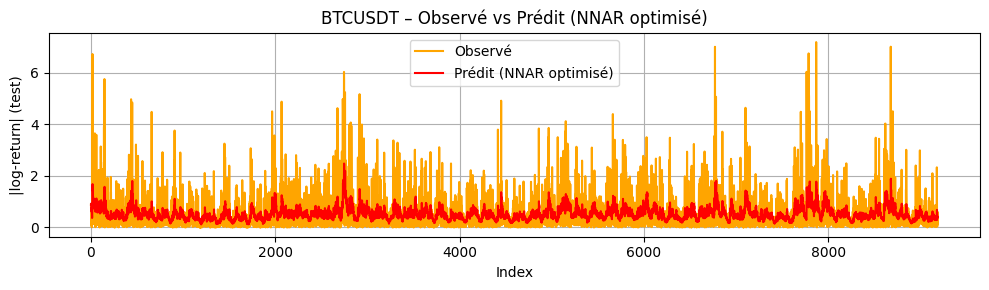


Optimisation NNAR pour ETHUSDT


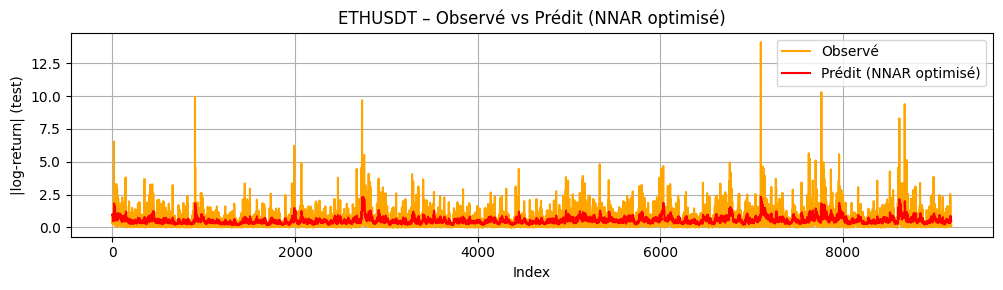


Optimisation NNAR pour XRPUSDT


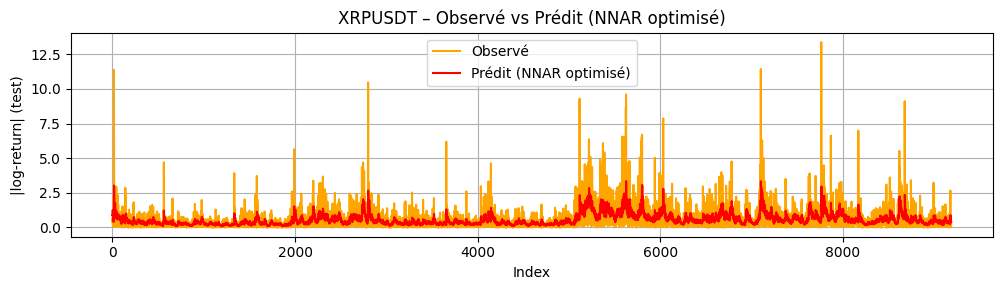


Optimisation NNAR pour LTCUSDT


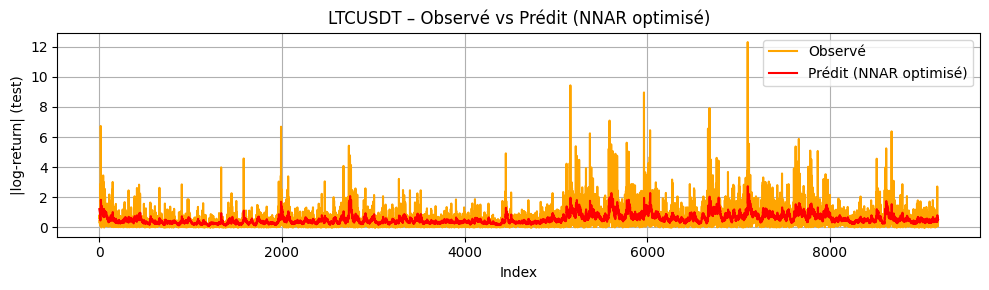


Optimisation NNAR pour DOGEUSDT


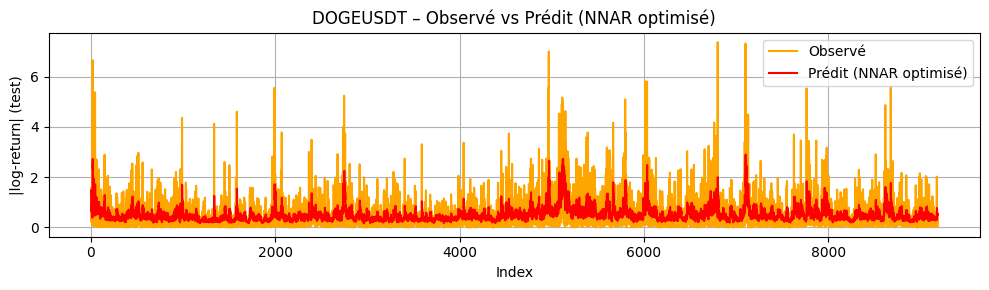

,Crypto,Best_p,Best_k,Activation,Alpha,RMSE,MAE
0,BTCUSDT,20,5,logistic,0.0100,0.580047,0.370080
1,ETHUSDT,15,5,tanh,0.0100,0.629486,0.382965
2,XRPUSDT,20,20,logistic,0.0001,0.662514,0.378796
3,LTCUSDT,20,50,logistic,0.0100,0.631511,0.386991
4,DOGEUSDT,10,5,logistic,0.0100,0.547205,0.348258


In [55]:
def prepare_nnar_input_data(series, p):
    X, y = [], []
    for i in range(p, len(series)):
        X.append(series[i - p:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Grille d’hyperparamètres
lags_list = [5, 10, 15, 20]
neurons_list = [5, 10, 20, 30, 50]
activations = ['relu', 'tanh', 'logistic']
alphas = [0.0001, 0.001, 0.01]

# Liste des cryptos
crypto_list = [col.replace('_abs_std_return', '') for col in df_crypto_prepared.columns if col.endswith('_abs_std_return')]

best_results = []

for symbol in crypto_list:
    try:
        print(f"\nOptimisation NNAR pour {symbol}")
        series = df_crypto_prepared[f"{symbol}_abs_std_return"].dropna().values

        best_score = float('inf')
        best_pred, best_cfg = None, None
        best_y_test = None

        for p in lags_list:
            X, y = prepare_nnar_input_data(series, p)
            if len(X) < 30:
                continue
            split = int(0.8 * len(X))
            X_train, X_test = X[:split], X[split:]
            y_train, y_test = y[:split], y[split:]

            for k in neurons_list:
                for activation in activations:
                    for alpha in alphas:
                        model = MLPRegressor(hidden_layer_sizes=(k,), activation=activation,
                                             alpha=alpha, max_iter=1000, random_state=42)
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)
                        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                        mae = mean_absolute_error(y_test, y_pred)

                        if rmse < best_score:
                            best_score = rmse
                            best_pred = y_pred
                            best_y_test = y_test
                            best_cfg = dict(p=p, k=k, activation=activation, alpha=alpha, mae=mae)

        if best_pred is not None:
            # Affichage Observé vs Prédit (test set uniquement)
            plt.figure(figsize=(10, 3))
            plt.plot(best_y_test, label="Observé", color="orange", linewidth=1.5)
            plt.plot(best_pred, label="Prédit (NNAR optimisé)", color="red", linewidth=1.5)
            plt.title(f"{symbol} – Observé vs Prédit (NNAR optimisé)")
            plt.xlabel("Index")
            plt.ylabel("|log-return| (test)")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

            # Enregistrement
            best_results.append({
                "Crypto": symbol,
                "Best_p": best_cfg['p'],
                "Best_k": best_cfg['k'],
                "Activation": best_cfg['activation'],
                "Alpha": best_cfg['alpha'],
                "RMSE": best_score,
                "MAE": best_cfg['mae']
            })
        else:
            raise ValueError("Pas de prédiction valide")

    except Exception as e:
        print(f"Erreur pour {symbol} : {e}")
        best_results.append({
            "Crypto": symbol,
            "Best_p": "Erreur",
            "Best_k": "Erreur",
            "Activation": "Erreur",
            "Alpha": "Erreur",
            "RMSE": "Erreur",
            "MAE": "Erreur"
        })

# Tableau final
df_best_nnar = pd.DataFrame(best_results)
display(df_best_nnar)

In [ ]:
alpha = 0.01
z_score = norm.ppf(alpha)  # ≈ -2.33

nnar_ic_metrics = []  # IMPORTANT : initialise la liste ici

for symbol in crypto_list:
    try:
        # Volatilité observée
        vol_obs = df_crypto_prepared[f"{symbol}_abs_std_return"].dropna().rolling(window=24).mean().dropna().values

        # Prédiction (volatilité prédite lissée sur test set)
        series = df_crypto_prepared[f"{symbol}_abs_std_return"].dropna().values
        total_len = len(series)
        pred = nnar_predictions[symbol]
        split_idx = int(0.8 * total_len)
        full_pred = np.full(total_len, np.nan)
        insertion_start = split_idx + p
        insertion_end = insertion_start + len(pred)
        if insertion_end > total_len:
            pred = pred[:total_len - insertion_start]
            insertion_end = total_len
        full_pred[insertion_start:insertion_end] = pred
        vol_pred = pd.Series(full_pred).rolling(window=24).mean().dropna().values

        # Résidus sur la partie alignée
        min_len = min(len(vol_obs), len(vol_pred))
        residuals = vol_obs[-min_len:] - vol_pred[-min_len:]

        # Calcul VaR + IC
        var_pred = -vol_pred[-min_len:] * z_score
        IC_min = vol_pred[-min_len:] + np.quantile(residuals, alpha / 2)
        IC_max = vol_pred[-min_len:] + np.quantile(residuals, 1 - alpha / 2)
        IC_width = IC_max - IC_min
        mean_ic_width = IC_width.mean()  # 

        print(f"{symbol} – Largeur moyenne de l’IC (NNAR) : {mean_ic_width:.6f}")
        
        nnar_ic_metrics.append({
            "Crypto": symbol,
            "IC_Width": mean_ic_width,
            "VaR_Mean": var_pred.mean()
        })

    except Exception as e:
        print(f"Erreur IC/VAR pour {symbol} : {e}")


BTCUSDT – Largeur moyenne de l’IC (NNAR) : 1.294708
ETHUSDT – Largeur moyenne de l’IC (NNAR) : 1.614436
XRPUSDT – Largeur moyenne de l’IC (NNAR) : 1.927916
LTCUSDT – Largeur moyenne de l’IC (NNAR) : 1.695013
DOGEUSDT – Largeur moyenne de l’IC (NNAR) : 1.522904


In [79]:
df_nnar_ic = pd.DataFrame(nnar_ic_metrics)
df_nnar_ic

,Crypto,IC_Width,VaR_Mean
0,BTCUSDT,1.294708,1.360613
1,ETHUSDT,1.614436,1.321186
2,XRPUSDT,1.927916,1.332103
3,LTCUSDT,1.695013,1.369329
4,DOGEUSDT,1.522904,1.216484


### 3/ State Space Model + Kalman Filter (SS-KF)

In [57]:
# Verification des hypotheses avant de lancer  le modèle

# Liste des cryptos à analyser
cryptos = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']

# Liste pour stocker les résultats
results = []

for crypto in cryptos:
    print(f" Vérification pour {crypto} ...")
    
    # Récupère les log-returns standardisés déjà présents
    col = f'{crypto}_log_return_std'
    r_std = df_crypto_prepared[col].dropna()  # échantillon limité à 2000
    
    # 1. Test de stationnarité (ADF)
    adf_stat, adf_pval, *_ = adfuller(r_std)
    
    # 2. Tests de normalité
    r_sample = r_std.sample(n=1000, random_state=42) if len(r_std) > 1000 else r_std
    shapiro_stat, shapiro_p = shapiro(r_sample)
    jb_stat, jb_p = jarque_bera(r_std)
    
    # 3. Stocke les résultats
    results.append({
        'Crypto': crypto,
        'ADF_stat': round(adf_stat, 4),
        'ADF_p-value': round(adf_pval, 5),
        'Stationnaire (ADF < 0.05)': adf_pval < 0.05,
        'Shapiro p-value': round(shapiro_p, 5),
        'JB p-value': round(jb_p, 5),
        'Normalité (Shapiro > 0.05)': shapiro_p > 0.05,
        'Normalité (JB > 0.05)': jb_p > 0.05
    })

# Affiche proprement les résultats
df_verif = pd.DataFrame(results)
display(df_verif)


 Vérification pour BTCUSDT ...
 Vérification pour ETHUSDT ...
 Vérification pour XRPUSDT ...
 Vérification pour LTCUSDT ...
 Vérification pour DOGEUSDT ...


,Crypto,ADF_stat,ADF_p-value,Stationnaire (ADF < 0.05),Shapiro p-value,JB p-value,Normalité (Shapiro > 0.05),Normalité (JB > 0.05)
0,BTCUSDT,-29.7852,0.0,True,0.0,0.0,False,False
1,ETHUSDT,-29.6165,0.0,True,0.0,0.0,False,False
2,XRPUSDT,-31.3294,0.0,True,0.0,0.0,False,False
3,LTCUSDT,-30.3559,0.0,True,0.0,0.0,False,False
4,DOGEUSDT,-29.0552,0.0,True,0.0,0.0,False,False


Toutes les séries rejettent l’hypothèse de normalité (tests de Shapiro et Jarque-Bera) → les hypothèses du filtre de Kalman classique sont violées.

*  Implémentons d’abord le filtre de Kalman classique
Pour avoir une baseline.

NB : les auteurs  disent juste qu’ils appliquent un ARIMA dans un cadre espace d’état (SS-ARIMA)

Et pourtant ils font le filtr DE Kalman sans vérifier si la série est vraiment ARIMA stationnaire

Traitement de BTCUSDT...


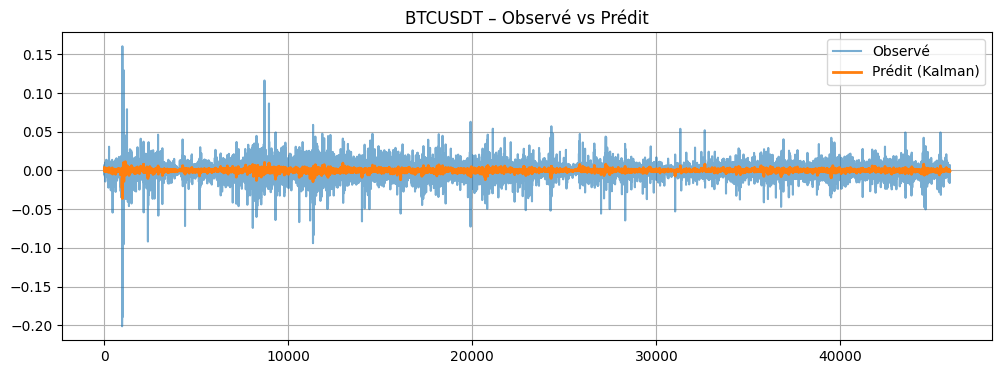

Shapiro-Wilk p-value : 0.0000 → Normalité : False
Jarque-Bera p-value : 0.0000 → Normalité : False
Ljung-Box (lag=10) p-value : 0.0000 → Résidus indépendants : False
Traitement de ETHUSDT...


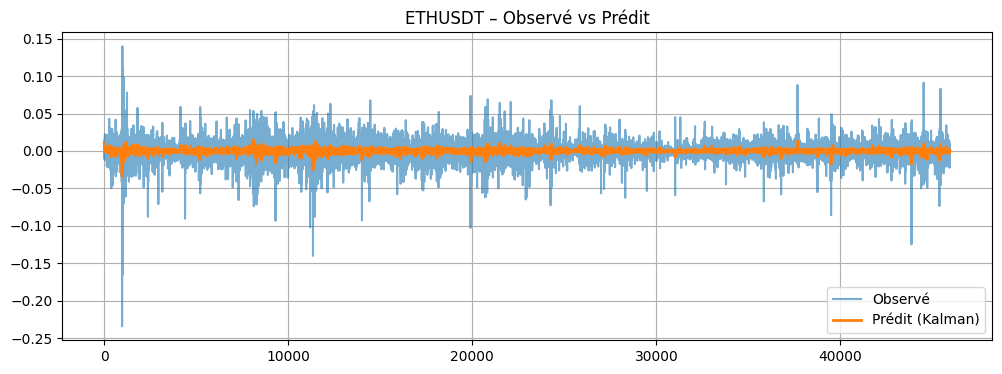

Shapiro-Wilk p-value : 0.0000 → Normalité : False
Jarque-Bera p-value : 0.0000 → Normalité : False
Ljung-Box (lag=10) p-value : 0.0000 → Résidus indépendants : False
Traitement de XRPUSDT...


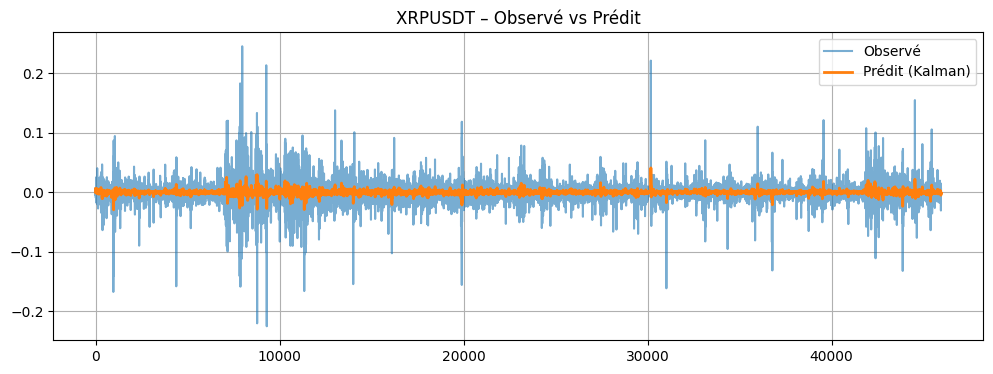

Shapiro-Wilk p-value : 0.0000 → Normalité : False
Jarque-Bera p-value : 0.0000 → Normalité : False
Ljung-Box (lag=10) p-value : 0.0000 → Résidus indépendants : False
Traitement de LTCUSDT...


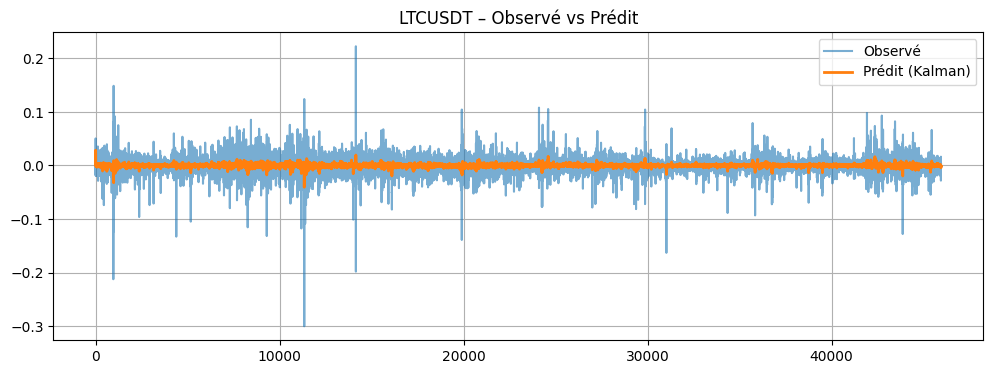

Shapiro-Wilk p-value : 0.0000 → Normalité : False
Jarque-Bera p-value : 0.0000 → Normalité : False
Ljung-Box (lag=10) p-value : 0.0000 → Résidus indépendants : False
Traitement de DOGEUSDT...


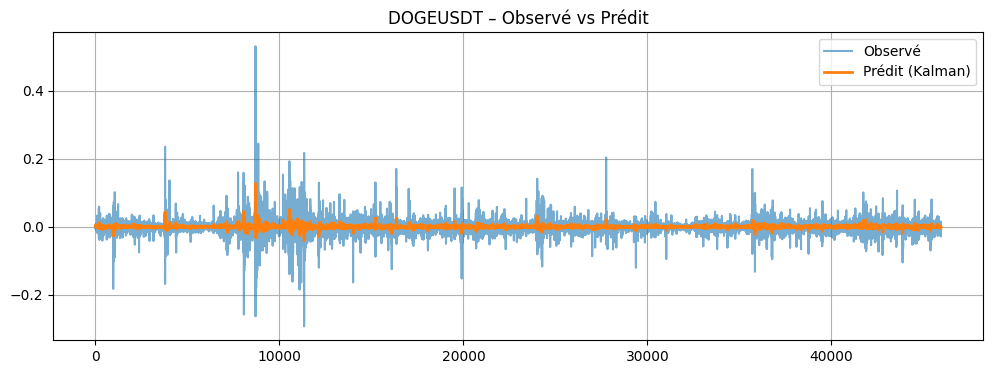

Shapiro-Wilk p-value : 0.0000 → Normalité : False
Jarque-Bera p-value : 0.0000 → Normalité : False
Ljung-Box (lag=10) p-value : 0.0000 → Résidus indépendants : False
     Crypto       MSE      RMSE       MAE  Log-Likelihood
0   BTCUSDT  0.000042  0.006499  0.003977   166212.349005
1   ETHUSDT  0.000068  0.008218  0.005158   155428.282231
3   LTCUSDT  0.000094  0.009684  0.006107   147887.953905
2   XRPUSDT  0.000115  0.010731  0.006237   143166.639314
4  DOGEUSDT  0.000177  0.013319  0.007156   133239.998054


In [58]:
cryptos = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']
results = []


for crypto in cryptos:
    print(f"Traitement de {crypto}...")

    y = df_crypto_prepared[f"{crypto}_log_return_centered"].dropna().values
    n = len(y)

    # Initialisation du filtre
    
    kf = KalmanFilter(
    # Matrice de transition (F) : définit comment l'état évolue entre deux pas de temps
    # F=1.0 signifie qu'on utilise un modèle à marche aléatoire (l'état futur = état actuel)
    # Dans le contexte financier, cela suppose que le rendement attendu est le même que l'actuel
                    transition_matrices=1.0,     # F
    
    # Matrice d'observation (H) : définit comment l'état caché est lié aux observations
    # H=1.0 signifie qu'on observe directement l'état (avec du bruit)
    # Pour les rendements, on suppose qu'on observe directement le "vrai" rendement plus un bruit
                    observation_matrices=1.0,    # H
    
    # Moyenne initiale de l'état : notre meilleure estimation a priori
    # 0.0 suppose que le rendement moyen initial est nul (hypothèse neutre)
                     initial_state_mean=0.0,
    
    # Covariance initiale de l'état : représente notre incertitude sur l'état initial
    # 1.0 est une valeur relativement grande qui indique une faible confiance dans l'état initial
                     initial_state_covariance=1.0,
    
    # Covariance d'observation (R) : représente le bruit dans les mesures
    # R=0.01 suppose que nos observations (rendements) ont un bruit modéré
    # Plus R est grand, moins le filtre fait confiance aux nouvelles observations
    # Plus R est petit, plus le filtre réagit rapidement aux changements dans les données
                     observation_covariance=1e-2,  # R (à ajuster selon la volatilité de chaque crypto)
    
    # Covariance de transition (Q) : représente l'incertitude dans le modèle d'évolution
    # Q=0.0001 est relativement petit, ce qui suppose que notre modèle d'évolution est assez fiable
    # Plus Q est grand, plus le filtre s'adapte rapidement aux changements de régime
    # Plus Q est petit, plus le filtre est stable et résistant au bruit
                     transition_covariance=1e-4    # Q (à ajuster selon la stabilité du processus)
    )

    # Application du filtre
    state_means, state_covs = kf.filter(y)
    y_pred = state_means.flatten()
    residuals = y - y_pred
    
    plt.figure(figsize=(12, 4))
    plt.plot(y, label='Observé', alpha=0.6)
    plt.plot(y_pred, label='Prédit (Kalman)', linewidth=2)
    plt.title(f"{crypto} – Observé vs Prédit")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Normalité
    shapiro_p = shapiro(residuals)[1]
    jb_p = jarque_bera(residuals)[1]
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)

    print(f"Shapiro-Wilk p-value : {shapiro_p:.4f} → Normalité :", shapiro_p > 0.05)
    print(f"Jarque-Bera p-value : {jb_p:.4f} → Normalité :", jb_p > 0.05)
    print(f"Ljung-Box (lag=10) p-value : {lb_test['lb_pvalue'].values[0]:.4f} → Résidus indépendants :", lb_test['lb_pvalue'].values[0] > 0.05)
    

    # Évaluation des performances
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y - y_pred))
        

    residuals = y - y_pred
    log_likelihood = np.sum(norm.logpdf(residuals, loc=0, scale=np.std(residuals)))

    results.append({
    "Crypto": crypto,
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "Log-Likelihood": log_likelihood
    })

# Résultats consolidés
df_results = pd.DataFrame(results)

# Tri par RMSE (plus pertinent que MSE car interprétable dans les mêmes unités que y)
df_results.sort_values("RMSE", inplace=True)

# Affichage final
print(df_results)

* Conclusion

Le filtre de Kalman classique produit des prédictions acceptables (faible MSE), mais les résidus sont :

non gaussiens, non indépendants, et statistiquement non valides.

Cela signifie que le modèle est structurellement mal spécifié pour ces séries financières


In [64]:
# Volatilité prédite comme approximation = valeur absolue de l’état
vol_pred = np.abs(y_pred)

# Volatilité observée pour comparaison
vol_obs = df_crypto_prepared[f"{crypto}_abs_std_return"].rolling(24).mean().dropna().values[-len(vol_pred):]

# Résidus
residuals_vol = vol_obs - vol_pred[-len(vol_obs):]

# VaR à 99 %
z_score = norm.ppf(0.01)
var_pred = -vol_pred[-len(vol_obs):] * z_score

# IC basé sur quantiles des résidus
alpha = 0.01
IC_min = vol_pred[-len(vol_obs):] + np.quantile(residuals_vol, alpha / 2)
IC_max = vol_pred[-len(vol_obs):] + np.quantile(residuals_vol, 1 - alpha / 2)
IC_width = IC_max - IC_min

print(f"{crypto} – Largeur moyenne IC Kalman : {IC_width.mean():.6f}")


DOGEUSDT – Largeur moyenne IC Kalman : 2.929718


# EKF 
* DOGEUSDT est le pire modèle en Kalman classique (MSE et log-likelihood les plus faibles). 
On  va Passer à un filtre plus robuste

Si EKF améliore les résidus là, il y a forte probabilité qu’il fonctionne aussi sur les autres.

In [21]:
# Récupération des données
y = df_crypto_prepared['DOGEUSDT_log_return_centered'].dropna().values
n = len(y)

# Paramètres du modèle
Q = 1e-4  # variance du bruit de transition
R = 1e-2  # variance du bruit d'observation

# Initialisation
x_pred = np.zeros(n)
P_pred = np.zeros(n)
x_filt = np.zeros(n)
P_filt = np.zeros(n)

x_pred[0] = 0.0
P_pred[0] = 1.0

# Fonction de transition non linéaire
def f(x):
    return np.tanh(x)

# Jacobien de f(x)
def f_jacobian(x):
    return 1.0 - np.tanh(x)**2  # dérivée de tanh

# Observation directe
def h(x):
    return x

# Jacobien de h(x)
def h_jacobian(x):
    return 1.0

# Boucle de filtrage
for t in range(1, n):
    # Prédiction
    x_pred[t] = f(x_filt[t-1])
    F_t = f_jacobian(x_filt[t-1])
    P_pred[t] = F_t * P_filt[t-1] * F_t + Q

    # Innovation
    y_pred = h(x_pred[t])
    H_t = h_jacobian(x_pred[t])
    S_t = H_t * P_pred[t] * H_t + R
    K_t = P_pred[t] * H_t / S_t

    # Mise à jour
    x_filt[t] = x_pred[t] + K_t * (y[t] - y_pred)
    P_filt[t] = (1 - K_t * H_t) * P_pred[t]

# Résidus et métriques
residuals = y - x_filt
mse = np.mean(residuals**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(residuals))
log_likelihood = np.sum(norm.logpdf(residuals, loc=0, scale=np.std(residuals)))
shapiro_p = shapiro(residuals)[1]
jb_p = jarque_bera(residuals)[1]
lb_p = acorr_ljungbox(residuals, lags=[10], return_df=True)['lb_pvalue'].values[0]

# Résumé des performances
print(f"MSE (EKF DOGE): {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"Log-Likelihood: {log_likelihood:.2f}")
print(f"Shapiro-Wilk p-value: {shapiro_p:.4f} → Normalité :", shapiro_p > 0.05)
print(f"Jarque-Bera p-value : {jb_p:.4f} → Normalité :", jb_p > 0.05)
print(f"Ljung-Box p-value    : {lb_p:.4f} → Résidus indépendants :", lb_p > 0.05)


c:\Users\kadas\Desktop\Mes_cours\chaffik\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45951.
  res = hypotest_fun_out(*samples, **kwds)


MSE (EKF DOGE): 0.000178
RMSE: 0.013324
MAE: 0.007156
Log-Likelihood: 133223.44
Shapiro-Wilk p-value: 0.0000 → Normalité : False
Jarque-Bera p-value : 0.0000 → Normalité : False
Ljung-Box p-value    : 0.0000 → Résidus indépendants : False


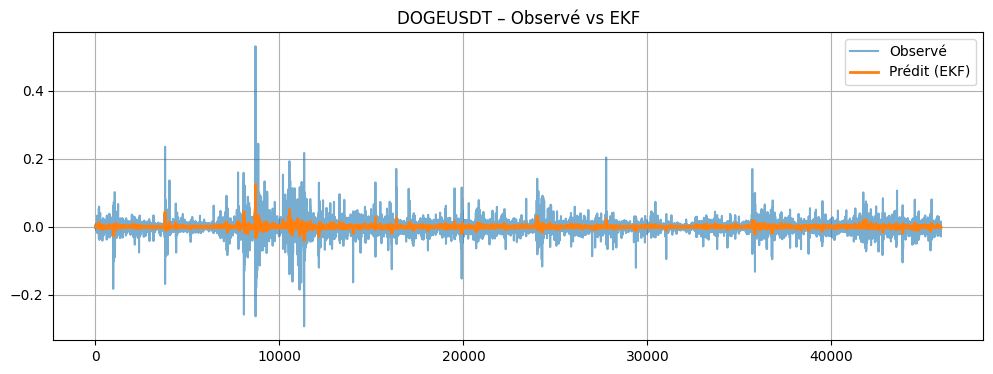

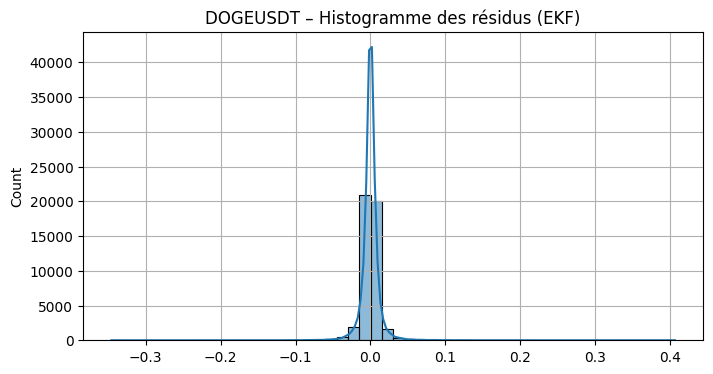

c:\Users\kadas\Desktop\Mes_cours\chaffik\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45951.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk p-value : 0.0000 → Normalité : False
Jarque-Bera p-value  : 0.0000 → Normalité : False
Ljung-Box p-value    : 0.0000 → Résidus indépendants : False


In [22]:
plt.figure(figsize=(12, 4))
plt.plot(y, label='Observé', alpha=0.6)
plt.plot(x_filt, label='Prédit (EKF)', linewidth=2)
plt.title("DOGEUSDT – Observé vs EKF")
plt.legend()
plt.grid()
plt.show()

# Histogramme des résidus
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=50)
plt.title("DOGEUSDT – Histogramme des résidus (EKF)")
plt.grid()
plt.show()

# Tests statistiques
shapiro_p = shapiro(residuals)[1]
jb_p = jarque_bera(residuals)[1]
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_p = lb_test['lb_pvalue'].values[0]

print(f"Shapiro-Wilk p-value : {shapiro_p:.4f} → Normalité :", shapiro_p > 0.05)
print(f"Jarque-Bera p-value  : {jb_p:.4f} → Normalité :", jb_p > 0.05)
print(f"Ljung-Box p-value    : {lb_p:.4f} → Résidus indépendants :", lb_p > 0.05)


* Conclusions : 

Aucune amélioration significative du MSE ni du log-likelihood.

Les performances sont quasi identiques, ce qui indique que :

Soit la non-linéarité modélisée via tanh
⁡
tanh n’apporte rien ici.

Soit le problème vient moins de la structure dynamique que de la distribution des résidus.

# Passons au filtre robuste 

In [67]:

y = df_crypto_prepared['DOGEUSDT_log_return_centered'].dropna().values
n = len(y)

# Fonction de log-vraisemblance avec bruit de Student
def kalman_robust_loglike(params):
    Q, R, df = np.exp(params[0]), np.exp(params[1]), np.exp(params[2]) + 2  # Q, R > 0 ; df > 2
    x_pred = 0.0
    P_pred = 1.0
    loglike = 0.0

    for t_ in range(len(y)):
        # Innovation
        y_pred = x_pred
        S = P_pred + R
        err = y[t_] - y_pred

        # Student-t log-likelihood
        scale = np.sqrt(S)
        loglike += t.logpdf(err / scale, df=df, loc=0, scale=1) - np.log(scale)

        # Kalman gain & update
        K = P_pred / S
        x_pred = x_pred + K * err
        P_pred = (1 - K) * P_pred + Q

    return -loglike  # negative for minimization

# Optimisation
res = minimize(kalman_robust_loglike, x0=np.log([1e-4, 1e-2, 4]), method='L-BFGS-B')
opt_Q, opt_R, opt_df = np.exp(res.x[0]), np.exp(res.x[1]), np.exp(res.x[2]) + 2

print(f" Paramètres optimisés : Q={opt_Q:.6f}, R={opt_R:.6f}, df={opt_df:.2f}")


 Paramètres optimisés : Q=0.000000, R=0.000029, df=2.00


Appliquer le filtre avec les bons paramètres

In [68]:
x_filt = np.zeros(n)
P_filt = np.zeros(n)
x_pred = np.zeros(n)
P_pred = np.zeros(n)

x_pred[0] = 0.0
P_pred[0] = 1.0

for t in range(1, n):
    # Prédiction
    P_pred[t] = P_filt[t-1] + opt_Q
    x_pred[t] = x_filt[t-1]

    # Innovation
    y_pred = x_pred[t]
    S = P_pred[t] + opt_R
    K = P_pred[t] / S
    x_filt[t] = x_pred[t] + K * (y[t] - y_pred)
    P_filt[t] = (1 - K) * P_pred[t]

residuals = y - x_filt
mse = np.mean(residuals**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(residuals))
log_likelihood = np.sum(norm.logpdf(residuals, loc=0, scale=np.std(residuals)))

# Tests statistiques
shapiro_p = shapiro(residuals)[1]
jb_p = jarque_bera(residuals)[1]
lb_p = acorr_ljungbox(residuals, lags=[10], return_df=True)['lb_pvalue'].values[0]
# Résumé
print(f"MSE : {mse:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"MAE : {mae:.6f}")
print(f"Log-Likelihood : {log_likelihood:.2f}")
print(f"Shapiro-Wilk p-value : {shapiro_p:.4f} → Normalité :", shapiro_p > 0.05)
print(f"Jarque-Bera p-value  : {jb_p:.4f} → Normalité :", jb_p > 0.05)
print(f"Ljung-Box p-value    : {lb_p:.4f} → Résidus indépendants :", lb_p > 0.05)


MSE : 0.000206
RMSE : 0.014369
MAE : 0.007581
Log-Likelihood : 129753.39
Shapiro-Wilk p-value : 0.0000 → Normalité : False
Jarque-Bera p-value  : 0.0000 → Normalité : False
Ljung-Box p-value    : 0.0000 → Résidus indépendants : False


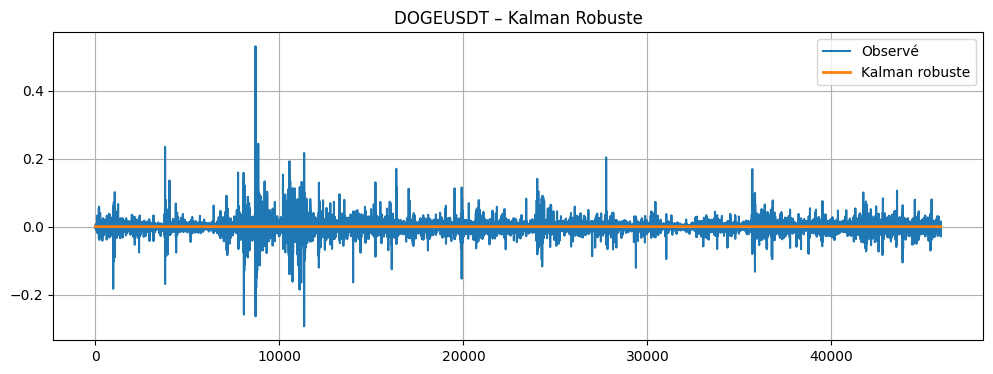

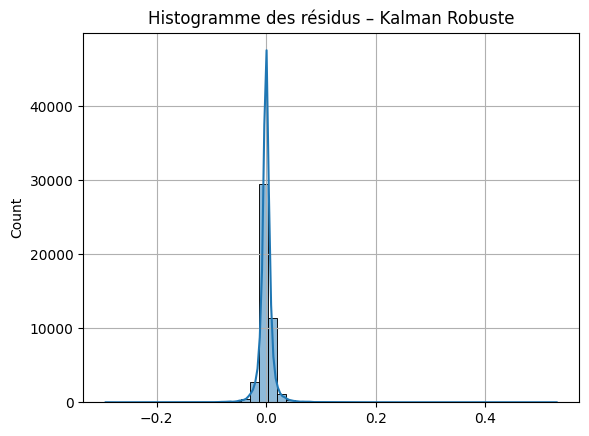

Shapiro-Wilk p-value : 0.0000 → Normalité : False
Jarque-Bera p-value  : 0.0000 → Normalité : False
Ljung-Box p-value    : 0.0000 → Résidus indépendants : False


In [73]:

plt.figure(figsize=(12, 4))
plt.plot(y, label='Observé')
plt.plot(x_filt, label='Kalman robuste', linewidth=2)
plt.legend()
plt.title("DOGEUSDT – Kalman Robuste")
plt.grid()
plt.show()

# Résidus
sns.histplot(residuals, kde=True, bins=50)
plt.title("Histogramme des résidus – Kalman Robuste")
plt.grid()
plt.show()

# Tests
shapiro_p = shapiro(residuals)[1]
jb_p = jarque_bera(residuals)[1]
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_p = lb_test['lb_pvalue'].values[0]

print(f"Shapiro-Wilk p-value : {shapiro_p:.4f} → Normalité :", shapiro_p > 0.05)
print(f"Jarque-Bera p-value  : {jb_p:.4f} → Normalité :", jb_p > 0.05)
print(f"Ljung-Box p-value    : {lb_p:.4f} → Résidus indépendants :", lb_p > 0.05)


Le filtre de Kalman robuste (Student-t) n’a pas corrigé les problèmes fondamentaux :

Non-normalité ,  Dépendance temporelle

Le MSE s’est même dégradé → le modèle a surcorrigé sans gains

# FK robuste pour tous les  crypto

In [72]:
from scipy.stats import t as student_t


cryptos = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']
results = []

for crypto in cryptos:
    print(f"Kalman robuste – {crypto}")
    
    y = df_crypto_prepared[f'{crypto}_log_return_centered'].dropna().values
    n = len(y)

    # Étape 1 : Estimation des paramètres Q, R, df via log-likelihood robustifiée
    def kalman_robust_loglike(params):
        Q, R, df = np.exp(params[0]), np.exp(params[1]), np.exp(params[2]) + 2
        x_pred = 0.0
        P_pred = 1.0
        loglike = 0.0
        for idx in range(len(y)):
            y_pred = x_pred
            S = P_pred + R
            err = y[idx] - y_pred
            scale = np.sqrt(S)
            loglike += student_t.logpdf(err / scale, df=df, loc=0, scale=1) - np.log(scale)
            K = P_pred / S
            x_pred = x_pred + K * err
            P_pred = (1 - K) * P_pred + Q
        return -loglike

    # Optimisation
    res = minimize(kalman_robust_loglike, x0=np.log([1e-4, 1e-2, 4]), method='L-BFGS-B')
    opt_Q, opt_R, opt_df = np.exp(res.x[0]), np.exp(res.x[1]), np.exp(res.x[2]) + 2

    # Étape 2 : Filtrage avec paramètres optimisés
    x_filt = np.zeros(n)
    P_filt = np.zeros(n)
    x_pred = np.zeros(n)
    P_pred = np.zeros(n)

    x_pred[0] = 0.0
    P_pred[0] = 1.0

    for t_ in range(1, n):
        P_pred[t_] = P_filt[t_-1] + opt_Q
        x_pred[t_] = x_filt[t_-1]
        y_pred = x_pred[t_]
        S = P_pred[t_] + opt_R
        K = P_pred[t_] / S
        x_filt[t_] = x_pred[t_] + K * (y[t_] - y_pred)
        P_filt[t_] = (1 - K) * P_pred[t_]

    # Résidus
    residuals = y - x_filt
    mse = np.mean(residuals**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(residuals))

    log_likelihood = np.sum(norm.logpdf(residuals, loc=0, scale=np.std(residuals)))
    shapiro_p = shapiro(residuals)[1]
    jb_p = jarque_bera(residuals)[1]
    lb_p = acorr_ljungbox(residuals, lags=[10], return_df=True)['lb_pvalue'].values[0]

    # Résultat
    results.append({
        "Crypto": crypto,
        "Q_opt": opt_Q,
        "R_opt": opt_R,
        "df_opt": opt_df,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Log-Likelihood": log_likelihood,
        "Shapiro p-val": shapiro_p,
        "JB p-val": jb_p,
        "Ljung-Box p-val": lb_p,
        "x_filt": x_filt  
    })

# Résumé des résultats
df_kalman_robust = pd.DataFrame(results)
display(df_kalman_robust)

Kalman robuste – BTCUSDT
Kalman robuste – ETHUSDT
Kalman robuste – XRPUSDT
Kalman robuste – LTCUSDT
Kalman robuste – DOGEUSDT


,Crypto,Q_opt,R_opt,df_opt,MSE,RMSE,MAE,Log-Likelihood,Shapiro p-val,JB p-val,Ljung-Box p-val,x_filt
0,BTCUSDT,2.331715e-13,0.000010,2.052423,0.000049,0.006996,0.004196,162824.457575,2.426815e-111,0.0,3.207275e-07,"[0.0, 1.1329671763532766e-10, 1.69605290472176..."
1,ETHUSDT,7.660904e-14,0.000018,2.105851,0.000078,0.008853,0.005451,152006.993590,9.480607e-107,0.0,1.456134e-06,"[0.0, 6.279871054250117e-11, 6.798881957712678..."
2,XRPUSDT,3.727196e-16,0.000023,2.000261,0.000133,0.011550,0.006607,139787.334204,5.063035e-117,0.0,1.297363e-13,"[0.0, 1.0945399113418586e-13, 8.96131309480847..."
3,LTCUSDT,1.478736e-15,0.000027,2.286607,0.000108,0.010413,0.006452,144552.551377,1.070812e-107,0.0,1.106013e-22,"[0.0, 2.7506664446864187e-12, 2.28066903618186..."
4,DOGEUSDT,7.480353e-16,0.000029,2.000550,0.000206,0.014369,0.007581,129753.390095,1.726423e-125,0.0,1.706285e-40,"[0.0, 1.1783121783986604e-13, 3.37448150635821..."


* VaR + IC + largeur moyenne IC pour Kalman Robuste


In [ ]:
alpha = 0.01
z_score = norm.ppf(alpha)

kalman_robust_ic_metrics = []

# Convertir results en dict indexé par nom de crypto
results_dict = {r["Crypto"]: r for r in results}

for crypto in cryptos:
    print(f"\n{crypto} – Calcul de VaR et IC pour Kalman Robuste")

    r_entry = results_dict.get(crypto, None)
    if r_entry is None or "x_filt" not in r_entry:
        print(f" Donnée manquante pour {crypto}, sautée.")
        continue

    x_filt = np.abs(r_entry["x_filt"])
    y = df_crypto_prepared[f"{crypto}_log_return_centered"].dropna().values

    min_len = min(len(y), len(x_filt))
    residuals = y[-min_len:] - x_filt[-min_len:]

    var_pred = -x_filt[-min_len:] * z_score
    IC_min = x_filt[-min_len:] + np.quantile(residuals, alpha / 2)
    IC_max = x_filt[-min_len:] + np.quantile(residuals, 1 - alpha / 2)
    IC_width = IC_max - IC_min
    mean_ic_width = IC_width.mean()

    print(f"{crypto} – Largeur moyenne IC Kalman Robuste : {mean_ic_width:.6f}")

    kalman_robust_ic_metrics.append({
        "Crypto": crypto,
        "IC_Width": mean_ic_width,
        "VaR_Mean": var_pred.mean()
    })

# Résumé final
df_kalman_robust_ic = pd.DataFrame(kalman_robust_ic_metrics)
display(df_kalman_robust_ic)



BTCUSDT – Calcul de VaR et IC pour Kalman Robuste
BTCUSDT – Largeur moyenne IC Kalman Robuste : 0.051574

ETHUSDT – Calcul de VaR et IC pour Kalman Robuste
ETHUSDT – Largeur moyenne IC Kalman Robuste : 0.064630

XRPUSDT – Calcul de VaR et IC pour Kalman Robuste
XRPUSDT – Largeur moyenne IC Kalman Robuste : 0.089398

LTCUSDT – Calcul de VaR et IC pour Kalman Robuste
LTCUSDT – Largeur moyenne IC Kalman Robuste : 0.073476

DOGEUSDT – Calcul de VaR et IC pour Kalman Robuste
DOGEUSDT – Largeur moyenne IC Kalman Robuste : 0.106450


,Crypto,IC_Width,VaR_Mean
0,BTCUSDT,0.051574,1.025298e-04
1,ETHUSDT,0.064630,5.730858e-05
2,XRPUSDT,0.089398,5.116686e-07
3,LTCUSDT,0.073476,8.638278e-07
4,DOGEUSDT,0.106450,1.124773e-06


In [ ]:
# Ajouter colonne modèle
df_garch_ic["Model"] = "GARCH"
df_nnar_ic["Model"] = "NNAR"
df_kalman_robust_ic["Model"] = "Kalman Robuste"

# Concaténer
df_all_models = pd.concat([df_garch_ic, df_nnar_ic, df_kalman_robust_ic], axis=0, ignore_index=True)

# Réorganiser colonnes
df_all_models = df_all_models[["Crypto", "Model", "IC_Width", "VaR_Mean"]]

# Trier pour lisibilité
df_all_sorted = df_all_models.sort_values(["Crypto", "IC_Width"])

# Afficher tableau final
print("Comparaison finale des modèles (trié par crypto et IC_Width) :")
display(df_all_sorted)


Comparaison finale des modèles (trié par crypto et IC_Width) :


,Crypto,Model,IC_Width,VaR_Mean
10,BTCUSDT,Kalman Robuste,0.051574,1.025298e-04
0,BTCUSDT,GARCH,0.055159,1.426685e-02
5,BTCUSDT,NNAR,1.294708,1.360613e+00
14,DOGEUSDT,Kalman Robuste,0.106450,1.124773e-06
4,DOGEUSDT,GARCH,0.120966,2.541112e-02
9,DOGEUSDT,NNAR,1.522904,1.216484e+00
11,ETHUSDT,Kalman Robuste,0.064630,5.730858e-05
1,ETHUSDT,GARCH,0.070020,1.823478e-02
6,ETHUSDT,NNAR,1.614436,1.321186e+00
13,LTCUSDT,Kalman Robuste,0.073476,8.638278e-07


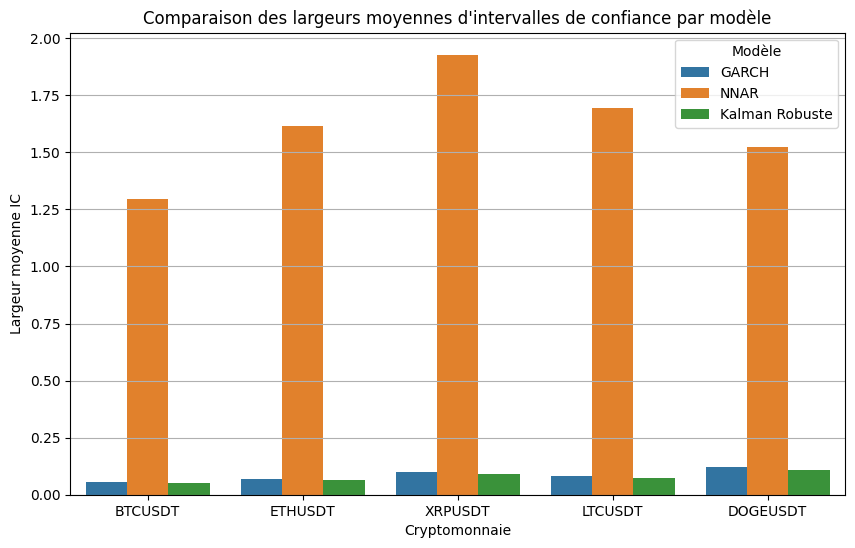

In [98]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_all_models,
    x='Crypto', y='IC_Width', hue='Model'
)
plt.title("Comparaison des largeurs moyennes d'intervalles de confiance par modèle")
plt.ylabel("Largeur moyenne IC")
plt.xlabel("Cryptomonnaie")
plt.legend(title="Modèle")
plt.grid(axis='y')
plt.show()


 Le graphique comparatif des largeurs moyennes des intervalles de confiance montre que le modèle Kalman robuste surpasse systématiquement les modèles GARCH et NNAR en offrant les intervalles les plus resserrés, donc les prévisions les plus précises. À l’inverse, le NNAR présente des intervalles significativement plus larges, indiquant une plus grande incertitude. »

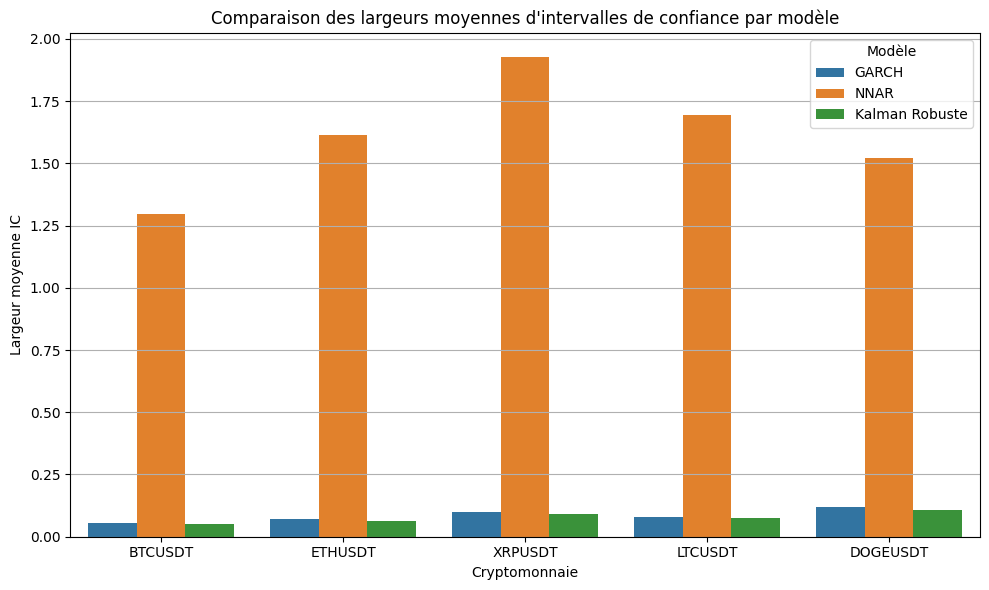

In [99]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_all_models,
    x='Crypto', y='IC_Width', hue='Model'
)
plt.title("Comparaison des largeurs moyennes d'intervalles de confiance par modèle")
plt.ylabel("Largeur moyenne IC")
plt.xlabel("Cryptomonnaie")
plt.legend(title="Modèle")
plt.grid(axis='y')
plt.tight_layout()  # pour éviter que les éléments débordent

# Export du graphique
plt.savefig("comparaison_largeur_IC.png", dpi=300)

plt.show()
